In [1]:
import math, re, os
import numpy as np
import tensorflow as tf
import torch as nn

print("Tensorflow version " + tf.__version__)
print("PyTorch Version " + nn.__version__)

D0427 18:53:26.813589054      13 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0427 18:53:26.813620094      13 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0427 18:53:26.813624111      13 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0427 18:53:26.813627450      13 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0427 18:53:26.813630221      13 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0427 18:53:26.813633191      13 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0427 18:53:26.813636700      13 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0427 18:53:26.

Tensorflow version 2.12.0
PyTorch Version 2.0.0+cu117


In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError as ve:
    tpu = None
    print(ve)

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [3]:
from kaggle_datasets import KaggleDatasets
import os

GCS_DS_PATH = KaggleDatasets().get_gcs_path('/kaggle/input/tpu-getting-started')
print(GCS_DS_PATH) # what do gcs paths look like?

/kaggle/input/tpu-getting-started


get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started


In [4]:
IMAGE_SIZE = [512, 512]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [5]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [6]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [7]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)
Training data label examples: [ 69  49  80 ...  53 103  18]


In [8]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)


(128, 512, 512, 3) (128,)
Test data IDs: ['73ff3946d' 'e58b03040' '3cc7863f5' ... 'ed127c922' '36c344ab5' '23253eaed']


In [9]:
from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [10]:
ds_iter = iter(ds_train.unbatch().batch(20))

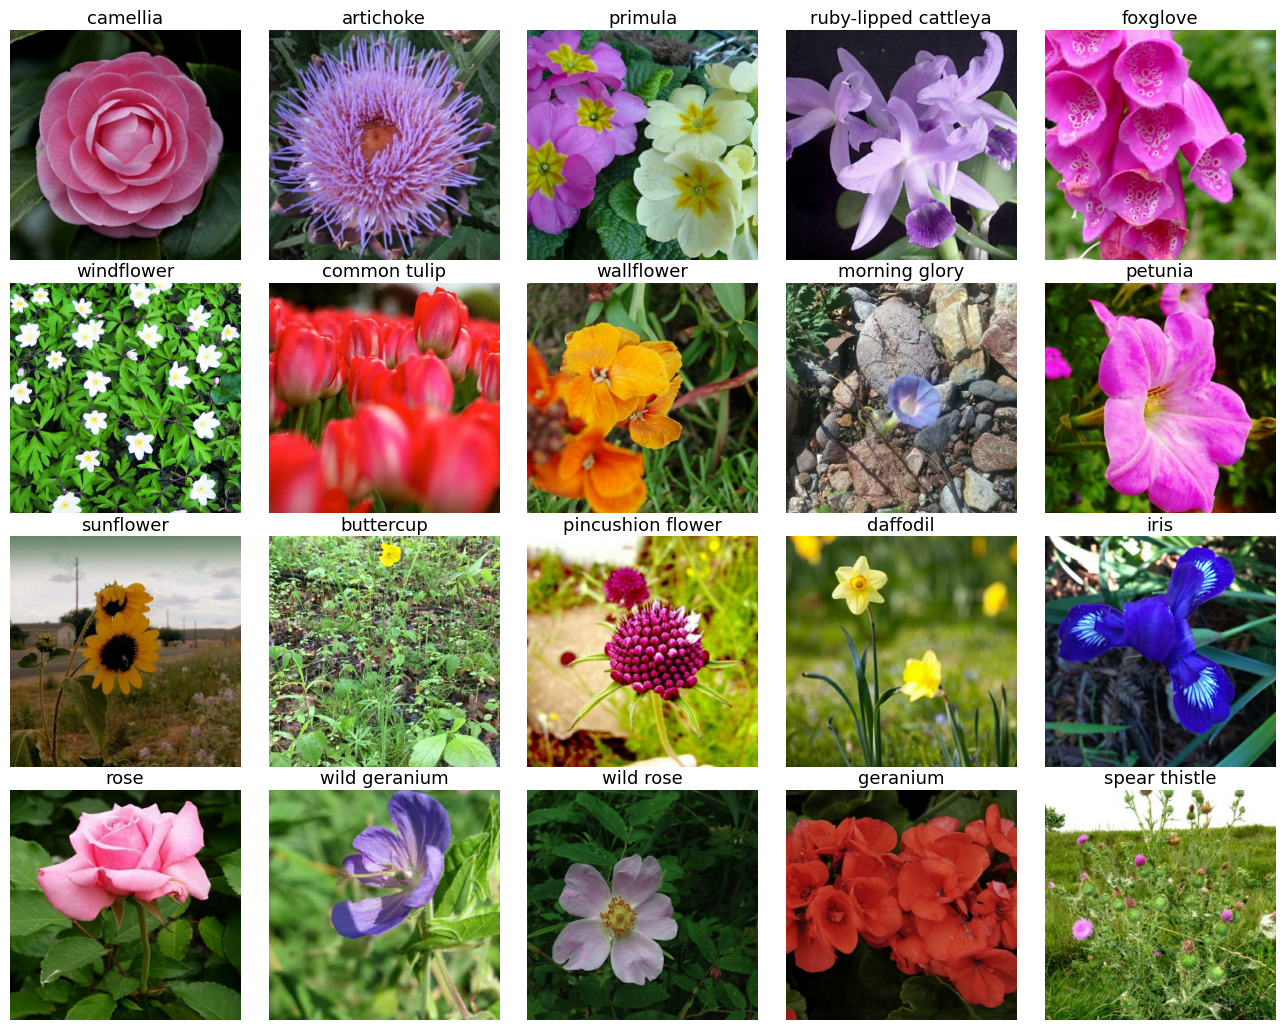

In [11]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

In [12]:
EPOCHS = 12

with strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

    8192/58889256 [..............................] - ETA: 0s

 4202496/58889256 [=>............................] - ETA: 1s

10166272/58889256 [====>.........................] - ETA: 0s

17571840/58889256 [=======>......................] - ETA: 0s

25116672/58889256 [===========>..................] - ETA: 0s

32694272/58889256 [===============>..............] - ETA: 0s

40099840/58889256 [===================>..........] - ETA: 0s

47702016/58889256 [=======================>......] - ETA: 0s

55271424/58889256 [===========================>..] - ETA: 0s

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 vgg16 (Functional)          (None, 16, 16, 512)       14714688  


 global_average_pooling2d (G  (None, 512)              0         


 lobalAveragePooling2D)                                          


 dense (Dense)               (None, 104)               53352     


Total params: 14,768,040


Trainable params: 53,352


Non-trainable params: 14,714,688


_________________________________________________________________


Learning rate schedule: 1e-05 to 5e-05 to 2.05e-05


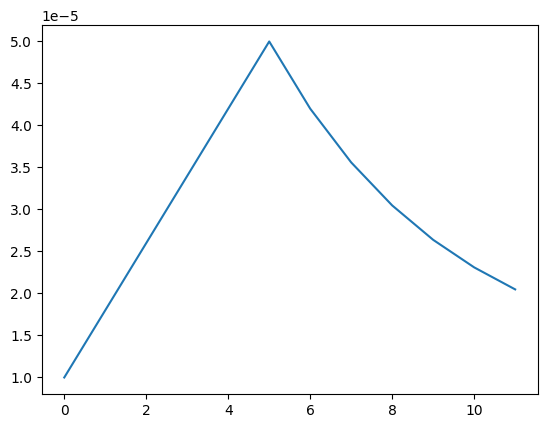

In [14]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [15]:
# Define training epochs
EPOCHS = 12
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.


Epoch 1/12


2023-04-27 18:54:26.039005: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-27 18:54:26.114307: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


 1/99 [..............................] - ETA: 18:18 - loss: 4.9621 - sparse_categorical_accuracy: 0.0234

 2/99 [..............................] - ETA: 36s - loss: 4.8529 - sparse_categorical_accuracy: 0.0312  

 3/99 [..............................] - ETA: 35s - loss: 4.8372 - sparse_categorical_accuracy: 0.0260

 4/99 [>.............................] - ETA: 34s - loss: 4.7939 - sparse_categorical_accuracy: 0.0273

 5/99 [>.............................] - ETA: 33s - loss: 4.7429 - sparse_categorical_accuracy: 0.0297

 6/99 [>.............................] - ETA: 33s - loss: 4.7149 - sparse_categorical_accuracy: 0.0339

 7/99 [=>............................] - ETA: 32s - loss: 4.6996 - sparse_categorical_accuracy: 0.0324

 8/99 [=>............................] - ETA: 32s - loss: 4.6595 - sparse_categorical_accuracy: 0.0410

 9/99 [=>............................] - ETA: 31s - loss: 4.6297 - sparse_categorical_accuracy: 0.0443

10/99 [==>...........................] - ETA: 31s - loss: 4.6201 - sparse_categorical_accuracy: 0.0430

11/99 [==>...........................] - ETA: 31s - loss: 4.6007 - sparse_categorical_accuracy: 0.0426

12/99 [==>...........................] - ETA: 31s - loss: 4.5877 - sparse_categorical_accuracy: 0.0430

13/99 [==>...........................] - ETA: 30s - loss: 4.5627 - sparse_categorical_accuracy: 0.0451

14/99 [===>..........................] - ETA: 30s - loss: 4.5444 - sparse_categorical_accuracy: 0.0469

15/99 [===>..........................] - ETA: 30s - loss: 4.5338 - sparse_categorical_accuracy: 0.0464

16/99 [===>..........................] - ETA: 29s - loss: 4.5236 - sparse_categorical_accuracy: 0.0469

17/99 [====>.........................] - ETA: 29s - loss: 4.5060 - sparse_categorical_accuracy: 0.0478

18/99 [====>.........................] - ETA: 28s - loss: 4.4943 - sparse_categorical_accuracy: 0.0473

19/99 [====>.........................] - ETA: 28s - loss: 4.4822 - sparse_categorical_accuracy: 0.0469

20/99 [=====>........................] - ETA: 28s - loss: 4.4686 - sparse_categorical_accuracy: 0.0461

21/99 [=====>........................] - ETA: 27s - loss: 4.4542 - sparse_categorical_accuracy: 0.0484

22/99 [=====>........................] - ETA: 27s - loss: 4.4429 - sparse_categorical_accuracy: 0.0494

23/99 [=====>........................] - ETA: 26s - loss: 4.4341 - sparse_categorical_accuracy: 0.0493

24/99 [======>.......................] - ETA: 26s - loss: 4.4242 - sparse_categorical_accuracy: 0.0485

25/99 [======>.......................] - ETA: 26s - loss: 4.4210 - sparse_categorical_accuracy: 0.0487

26/99 [======>.......................] - ETA: 25s - loss: 4.4105 - sparse_categorical_accuracy: 0.0487

27/99 [=======>......................] - ETA: 25s - loss: 4.4025 - sparse_categorical_accuracy: 0.0489

28/99 [=======>......................] - ETA: 24s - loss: 4.3900 - sparse_categorical_accuracy: 0.0502

29/99 [=======>......................] - ETA: 24s - loss: 4.3818 - sparse_categorical_accuracy: 0.0504

30/99 [========>.....................] - ETA: 24s - loss: 4.3740 - sparse_categorical_accuracy: 0.0497

31/99 [========>.....................] - ETA: 24s - loss: 4.3686 - sparse_categorical_accuracy: 0.0491

32/99 [========>.....................] - ETA: 23s - loss: 4.3609 - sparse_categorical_accuracy: 0.0500

33/99 [=========>....................] - ETA: 23s - loss: 4.3524 - sparse_categorical_accuracy: 0.0518

34/99 [=========>....................] - ETA: 23s - loss: 4.3445 - sparse_categorical_accuracy: 0.0528

35/99 [=========>....................] - ETA: 22s - loss: 4.3357 - sparse_categorical_accuracy: 0.0525

36/99 [=========>....................] - ETA: 22s - loss: 4.3314 - sparse_categorical_accuracy: 0.0523

37/99 [==========>...................] - ETA: 22s - loss: 4.3231 - sparse_categorical_accuracy: 0.0530

38/99 [==========>...................] - ETA: 21s - loss: 4.3195 - sparse_categorical_accuracy: 0.0539

39/99 [==========>...................] - ETA: 21s - loss: 4.3152 - sparse_categorical_accuracy: 0.0547

40/99 [===========>..................] - ETA: 21s - loss: 4.3058 - sparse_categorical_accuracy: 0.0555

41/99 [===========>..................] - ETA: 20s - loss: 4.2997 - sparse_categorical_accuracy: 0.0572

42/99 [===========>..................] - ETA: 20s - loss: 4.2938 - sparse_categorical_accuracy: 0.0580

43/99 [============>.................] - ETA: 20s - loss: 4.2884 - sparse_categorical_accuracy: 0.0590

44/99 [============>.................] - ETA: 19s - loss: 4.2824 - sparse_categorical_accuracy: 0.0597

45/99 [============>.................] - ETA: 19s - loss: 4.2794 - sparse_categorical_accuracy: 0.0597

46/99 [============>.................] - ETA: 18s - loss: 4.2734 - sparse_categorical_accuracy: 0.0594

47/99 [=============>................] - ETA: 18s - loss: 4.2669 - sparse_categorical_accuracy: 0.0610

48/99 [=============>................] - ETA: 18s - loss: 4.2631 - sparse_categorical_accuracy: 0.0614

49/99 [=============>................] - ETA: 17s - loss: 4.2571 - sparse_categorical_accuracy: 0.0615

50/99 [==============>...............] - ETA: 17s - loss: 4.2516 - sparse_categorical_accuracy: 0.0625

51/99 [==============>...............] - ETA: 17s - loss: 4.2485 - sparse_categorical_accuracy: 0.0633

52/99 [==============>...............] - ETA: 16s - loss: 4.2445 - sparse_categorical_accuracy: 0.0636

53/99 [===============>..............] - ETA: 16s - loss: 4.2406 - sparse_categorical_accuracy: 0.0644

54/99 [===============>..............] - ETA: 16s - loss: 4.2375 - sparse_categorical_accuracy: 0.0644

55/99 [===============>..............] - ETA: 15s - loss: 4.2316 - sparse_categorical_accuracy: 0.0649

56/99 [===============>..............] - ETA: 15s - loss: 4.2265 - sparse_categorical_accuracy: 0.0653

57/99 [================>.............] - ETA: 15s - loss: 4.2216 - sparse_categorical_accuracy: 0.0662

58/99 [================>.............] - ETA: 14s - loss: 4.2184 - sparse_categorical_accuracy: 0.0672

59/99 [================>.............] - ETA: 14s - loss: 4.2157 - sparse_categorical_accuracy: 0.0678

60/99 [=================>............] - ETA: 13s - loss: 4.2135 - sparse_categorical_accuracy: 0.0674

61/99 [=================>............] - ETA: 13s - loss: 4.2109 - sparse_categorical_accuracy: 0.0680

62/99 [=================>............] - ETA: 13s - loss: 4.2089 - sparse_categorical_accuracy: 0.0683

63/99 [==================>...........] - ETA: 12s - loss: 4.2062 - sparse_categorical_accuracy: 0.0688

64/99 [==================>...........] - ETA: 12s - loss: 4.2046 - sparse_categorical_accuracy: 0.0687

65/99 [==================>...........] - ETA: 12s - loss: 4.2025 - sparse_categorical_accuracy: 0.0696

66/99 [===================>..........] - ETA: 11s - loss: 4.1994 - sparse_categorical_accuracy: 0.0703

67/99 [===================>..........] - ETA: 11s - loss: 4.1943 - sparse_categorical_accuracy: 0.0708

68/99 [===================>..........] - ETA: 11s - loss: 4.1939 - sparse_categorical_accuracy: 0.0711

69/99 [===================>..........] - ETA: 10s - loss: 4.1901 - sparse_categorical_accuracy: 0.0720

70/99 [====================>.........] - ETA: 10s - loss: 4.1845 - sparse_categorical_accuracy: 0.0734

71/99 [====================>.........] - ETA: 9s - loss: 4.1812 - sparse_categorical_accuracy: 0.0736 

72/99 [====================>.........] - ETA: 9s - loss: 4.1797 - sparse_categorical_accuracy: 0.0735

73/99 [=====================>........] - ETA: 9s - loss: 4.1775 - sparse_categorical_accuracy: 0.0738

74/99 [=====================>........] - ETA: 8s - loss: 4.1750 - sparse_categorical_accuracy: 0.0742

75/99 [=====================>........] - ETA: 8s - loss: 4.1747 - sparse_categorical_accuracy: 0.0745

76/99 [======================>.......] - ETA: 8s - loss: 4.1734 - sparse_categorical_accuracy: 0.0741

77/99 [======================>.......] - ETA: 7s - loss: 4.1695 - sparse_categorical_accuracy: 0.0748

78/99 [======================>.......] - ETA: 7s - loss: 4.1667 - sparse_categorical_accuracy: 0.0752

79/99 [======================>.......] - ETA: 7s - loss: 4.1631 - sparse_categorical_accuracy: 0.0753

80/99 [=======================>......] - ETA: 6s - loss: 4.1596 - sparse_categorical_accuracy: 0.0757

81/99 [=======================>......] - ETA: 6s - loss: 4.1562 - sparse_categorical_accuracy: 0.0763

82/99 [=======================>......] - ETA: 6s - loss: 4.1535 - sparse_categorical_accuracy: 0.0770

83/99 [========================>.....] - ETA: 5s - loss: 4.1519 - sparse_categorical_accuracy: 0.0775

84/99 [========================>.....] - ETA: 5s - loss: 4.1483 - sparse_categorical_accuracy: 0.0783

85/99 [========================>.....] - ETA: 4s - loss: 4.1460 - sparse_categorical_accuracy: 0.0786

86/99 [=========================>....] - ETA: 4s - loss: 4.1441 - sparse_categorical_accuracy: 0.0798

87/99 [=========================>....] - ETA: 4s - loss: 4.1429 - sparse_categorical_accuracy: 0.0798

88/99 [=========================>....] - ETA: 3s - loss: 4.1384 - sparse_categorical_accuracy: 0.0815

89/99 [=========================>....] - ETA: 3s - loss: 4.1351 - sparse_categorical_accuracy: 0.0826

90/99 [==========================>...] - ETA: 3s - loss: 4.1341 - sparse_categorical_accuracy: 0.0831

91/99 [==========================>...] - ETA: 2s - loss: 4.1320 - sparse_categorical_accuracy: 0.0836

92/99 [==========================>...] - ETA: 2s - loss: 4.1300 - sparse_categorical_accuracy: 0.0841

93/99 [===========================>..] - ETA: 2s - loss: 4.1269 - sparse_categorical_accuracy: 0.0847

94/99 [===========================>..] - ETA: 1s - loss: 4.1256 - sparse_categorical_accuracy: 0.0854

95/99 [===========================>..] - ETA: 1s - loss: 4.1234 - sparse_categorical_accuracy: 0.0859

96/99 [============================>.] - ETA: 1s - loss: 4.1219 - sparse_categorical_accuracy: 0.0865

97/99 [============================>.] - ETA: 0s - loss: 4.1192 - sparse_categorical_accuracy: 0.0869

98/99 [============================>.] - ETA: 0s - loss: 4.1175 - sparse_categorical_accuracy: 0.0877

99/99 [==============================] - ETA: 0s - loss: 4.1149 - sparse_categorical_accuracy: 0.0885

2023-04-27 18:55:11.881817: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-27 18:55:12.013190: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 64s 539ms/step - loss: 4.1149 - sparse_categorical_accuracy: 0.0885 - val_loss: 3.8878 - val_sparse_categorical_accuracy: 0.1587 - lr: 0.0010



Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.


Epoch 2/12


 1/99 [..............................] - ETA: 32s - loss: 3.9023 - sparse_categorical_accuracy: 0.1328

 2/99 [..............................] - ETA: 32s - loss: 3.9512 - sparse_categorical_accuracy: 0.1562

 3/99 [..............................] - ETA: 34s - loss: 3.8963 - sparse_categorical_accuracy: 0.1510

 4/99 [>.............................] - ETA: 33s - loss: 3.9134 - sparse_categorical_accuracy: 0.1602

 5/99 [>.............................] - ETA: 33s - loss: 3.9204 - sparse_categorical_accuracy: 0.1500

 6/99 [>.............................] - ETA: 33s - loss: 3.9259 - sparse_categorical_accuracy: 0.1484

 7/99 [=>............................] - ETA: 33s - loss: 3.9254 - sparse_categorical_accuracy: 0.1529

 8/99 [=>............................] - ETA: 33s - loss: 3.9370 - sparse_categorical_accuracy: 0.1494

 9/99 [=>............................] - ETA: 33s - loss: 3.9221 - sparse_categorical_accuracy: 0.1502

10/99 [==>...........................] - ETA: 33s - loss: 3.9274 - sparse_categorical_accuracy: 0.1469

11/99 [==>...........................] - ETA: 32s - loss: 3.9128 - sparse_categorical_accuracy: 0.1506

12/99 [==>...........................] - ETA: 32s - loss: 3.9010 - sparse_categorical_accuracy: 0.1536

13/99 [==>...........................] - ETA: 31s - loss: 3.8950 - sparse_categorical_accuracy: 0.1569

14/99 [===>..........................] - ETA: 31s - loss: 3.8911 - sparse_categorical_accuracy: 0.1562

15/99 [===>..........................] - ETA: 30s - loss: 3.9011 - sparse_categorical_accuracy: 0.1547

16/99 [===>..........................] - ETA: 30s - loss: 3.9033 - sparse_categorical_accuracy: 0.1509

17/99 [====>.........................] - ETA: 29s - loss: 3.9008 - sparse_categorical_accuracy: 0.1503

18/99 [====>.........................] - ETA: 29s - loss: 3.8912 - sparse_categorical_accuracy: 0.1484

19/99 [====>.........................] - ETA: 28s - loss: 3.8923 - sparse_categorical_accuracy: 0.1472

20/99 [=====>........................] - ETA: 28s - loss: 3.8881 - sparse_categorical_accuracy: 0.1492

21/99 [=====>........................] - ETA: 28s - loss: 3.8925 - sparse_categorical_accuracy: 0.1458

22/99 [=====>........................] - ETA: 27s - loss: 3.8888 - sparse_categorical_accuracy: 0.1449

23/99 [=====>........................] - ETA: 27s - loss: 3.8805 - sparse_categorical_accuracy: 0.1457

24/99 [======>.......................] - ETA: 26s - loss: 3.8766 - sparse_categorical_accuracy: 0.1471

25/99 [======>.......................] - ETA: 26s - loss: 3.8760 - sparse_categorical_accuracy: 0.1472

26/99 [======>.......................] - ETA: 26s - loss: 3.8714 - sparse_categorical_accuracy: 0.1499

27/99 [=======>......................] - ETA: 25s - loss: 3.8722 - sparse_categorical_accuracy: 0.1502

28/99 [=======>......................] - ETA: 25s - loss: 3.8730 - sparse_categorical_accuracy: 0.1509

29/99 [=======>......................] - ETA: 25s - loss: 3.8738 - sparse_categorical_accuracy: 0.1511

30/99 [========>.....................] - ETA: 24s - loss: 3.8732 - sparse_categorical_accuracy: 0.1526

31/99 [========>.....................] - ETA: 24s - loss: 3.8696 - sparse_categorical_accuracy: 0.1552

32/99 [========>.....................] - ETA: 24s - loss: 3.8682 - sparse_categorical_accuracy: 0.1562

33/99 [=========>....................] - ETA: 23s - loss: 3.8722 - sparse_categorical_accuracy: 0.1544

34/99 [=========>....................] - ETA: 23s - loss: 3.8694 - sparse_categorical_accuracy: 0.1558

35/99 [=========>....................] - ETA: 22s - loss: 3.8664 - sparse_categorical_accuracy: 0.1576

36/99 [=========>....................] - ETA: 22s - loss: 3.8652 - sparse_categorical_accuracy: 0.1584

37/99 [==========>...................] - ETA: 22s - loss: 3.8623 - sparse_categorical_accuracy: 0.1586

38/99 [==========>...................] - ETA: 21s - loss: 3.8578 - sparse_categorical_accuracy: 0.1595

39/99 [==========>...................] - ETA: 21s - loss: 3.8564 - sparse_categorical_accuracy: 0.1595

40/99 [===========>..................] - ETA: 21s - loss: 3.8538 - sparse_categorical_accuracy: 0.1611

41/99 [===========>..................] - ETA: 20s - loss: 3.8503 - sparse_categorical_accuracy: 0.1631

42/99 [===========>..................] - ETA: 20s - loss: 3.8492 - sparse_categorical_accuracy: 0.1644

43/99 [============>.................] - ETA: 19s - loss: 3.8479 - sparse_categorical_accuracy: 0.1644

44/99 [============>.................] - ETA: 19s - loss: 3.8434 - sparse_categorical_accuracy: 0.1660

45/99 [============>.................] - ETA: 19s - loss: 3.8449 - sparse_categorical_accuracy: 0.1655

46/99 [============>.................] - ETA: 18s - loss: 3.8434 - sparse_categorical_accuracy: 0.1656

47/99 [=============>................] - ETA: 18s - loss: 3.8414 - sparse_categorical_accuracy: 0.1654

48/99 [=============>................] - ETA: 18s - loss: 3.8406 - sparse_categorical_accuracy: 0.1655

49/99 [=============>................] - ETA: 17s - loss: 3.8434 - sparse_categorical_accuracy: 0.1657

50/99 [==============>...............] - ETA: 17s - loss: 3.8381 - sparse_categorical_accuracy: 0.1659

51/99 [==============>...............] - ETA: 17s - loss: 3.8386 - sparse_categorical_accuracy: 0.1656

52/99 [==============>...............] - ETA: 16s - loss: 3.8359 - sparse_categorical_accuracy: 0.1659

53/99 [===============>..............] - ETA: 16s - loss: 3.8375 - sparse_categorical_accuracy: 0.1660

54/99 [===============>..............] - ETA: 15s - loss: 3.8354 - sparse_categorical_accuracy: 0.1667

55/99 [===============>..............] - ETA: 15s - loss: 3.8330 - sparse_categorical_accuracy: 0.1672

56/99 [===============>..............] - ETA: 15s - loss: 3.8315 - sparse_categorical_accuracy: 0.1669

57/99 [================>.............] - ETA: 14s - loss: 3.8326 - sparse_categorical_accuracy: 0.1657

58/99 [================>.............] - ETA: 14s - loss: 3.8298 - sparse_categorical_accuracy: 0.1665

59/99 [================>.............] - ETA: 14s - loss: 3.8308 - sparse_categorical_accuracy: 0.1662

60/99 [=================>............] - ETA: 13s - loss: 3.8293 - sparse_categorical_accuracy: 0.1660

61/99 [=================>............] - ETA: 13s - loss: 3.8278 - sparse_categorical_accuracy: 0.1664

62/99 [=================>............] - ETA: 13s - loss: 3.8285 - sparse_categorical_accuracy: 0.1666

63/99 [==================>...........] - ETA: 12s - loss: 3.8258 - sparse_categorical_accuracy: 0.1675

64/99 [==================>...........] - ETA: 12s - loss: 3.8259 - sparse_categorical_accuracy: 0.1672

65/99 [==================>...........] - ETA: 12s - loss: 3.8234 - sparse_categorical_accuracy: 0.1680

66/99 [===================>..........] - ETA: 11s - loss: 3.8194 - sparse_categorical_accuracy: 0.1694

67/99 [===================>..........] - ETA: 11s - loss: 3.8195 - sparse_categorical_accuracy: 0.1697

68/99 [===================>..........] - ETA: 10s - loss: 3.8162 - sparse_categorical_accuracy: 0.1706

69/99 [===================>..........] - ETA: 10s - loss: 3.8167 - sparse_categorical_accuracy: 0.1706

70/99 [====================>.........] - ETA: 10s - loss: 3.8137 - sparse_categorical_accuracy: 0.1706

71/99 [====================>.........] - ETA: 9s - loss: 3.8112 - sparse_categorical_accuracy: 0.1709 

72/99 [====================>.........] - ETA: 9s - loss: 3.8104 - sparse_categorical_accuracy: 0.1720

73/99 [=====================>........] - ETA: 9s - loss: 3.8103 - sparse_categorical_accuracy: 0.1724

74/99 [=====================>........] - ETA: 8s - loss: 3.8087 - sparse_categorical_accuracy: 0.1728

75/99 [=====================>........] - ETA: 8s - loss: 3.8073 - sparse_categorical_accuracy: 0.1734

76/99 [======================>.......] - ETA: 8s - loss: 3.8058 - sparse_categorical_accuracy: 0.1744

77/99 [======================>.......] - ETA: 7s - loss: 3.8060 - sparse_categorical_accuracy: 0.1742

78/99 [======================>.......] - ETA: 7s - loss: 3.8043 - sparse_categorical_accuracy: 0.1750

79/99 [======================>.......] - ETA: 7s - loss: 3.8062 - sparse_categorical_accuracy: 0.1741

80/99 [=======================>......] - ETA: 6s - loss: 3.8064 - sparse_categorical_accuracy: 0.1742

81/99 [=======================>......] - ETA: 6s - loss: 3.8060 - sparse_categorical_accuracy: 0.1742

82/99 [=======================>......] - ETA: 5s - loss: 3.8062 - sparse_categorical_accuracy: 0.1738

83/99 [========================>.....] - ETA: 5s - loss: 3.8055 - sparse_categorical_accuracy: 0.1737

84/99 [========================>.....] - ETA: 5s - loss: 3.8028 - sparse_categorical_accuracy: 0.1737

85/99 [========================>.....] - ETA: 4s - loss: 3.8013 - sparse_categorical_accuracy: 0.1744

86/99 [=========================>....] - ETA: 4s - loss: 3.8008 - sparse_categorical_accuracy: 0.1750

87/99 [=========================>....] - ETA: 4s - loss: 3.7982 - sparse_categorical_accuracy: 0.1747

88/99 [=========================>....] - ETA: 3s - loss: 3.7976 - sparse_categorical_accuracy: 0.1751

89/99 [=========================>....] - ETA: 3s - loss: 3.7979 - sparse_categorical_accuracy: 0.1745

90/99 [==========================>...] - ETA: 3s - loss: 3.7967 - sparse_categorical_accuracy: 0.1751

91/99 [==========================>...] - ETA: 2s - loss: 3.7940 - sparse_categorical_accuracy: 0.1752

92/99 [==========================>...] - ETA: 2s - loss: 3.7929 - sparse_categorical_accuracy: 0.1755

93/99 [===========================>..] - ETA: 2s - loss: 3.7920 - sparse_categorical_accuracy: 0.1760

94/99 [===========================>..] - ETA: 1s - loss: 3.7918 - sparse_categorical_accuracy: 0.1757

95/99 [===========================>..] - ETA: 1s - loss: 3.7902 - sparse_categorical_accuracy: 0.1755

96/99 [============================>.] - ETA: 1s - loss: 3.7875 - sparse_categorical_accuracy: 0.1764

97/99 [============================>.] - ETA: 0s - loss: 3.7876 - sparse_categorical_accuracy: 0.1767

98/99 [============================>.] - ETA: 0s - loss: 3.7875 - sparse_categorical_accuracy: 0.1766

99/99 [==============================] - ETA: 0s - loss: 3.7857 - sparse_categorical_accuracy: 0.1765

99/99 [==============================] - 45s 453ms/step - loss: 3.7857 - sparse_categorical_accuracy: 0.1765 - val_loss: 3.6841 - val_sparse_categorical_accuracy: 0.2115 - lr: 8.1000e-04



Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.


Epoch 3/12


 1/99 [..............................] - ETA: 32s - loss: 3.8411 - sparse_categorical_accuracy: 0.1328

 2/99 [..............................] - ETA: 33s - loss: 3.7391 - sparse_categorical_accuracy: 0.1875

 3/99 [..............................] - ETA: 32s - loss: 3.6881 - sparse_categorical_accuracy: 0.1927

 4/99 [>.............................] - ETA: 32s - loss: 3.6783 - sparse_categorical_accuracy: 0.1953

 5/99 [>.............................] - ETA: 32s - loss: 3.6781 - sparse_categorical_accuracy: 0.2062

 6/99 [>.............................] - ETA: 32s - loss: 3.6934 - sparse_categorical_accuracy: 0.1966

 7/99 [=>............................] - ETA: 31s - loss: 3.7052 - sparse_categorical_accuracy: 0.1864

 8/99 [=>............................] - ETA: 31s - loss: 3.7200 - sparse_categorical_accuracy: 0.1855

 9/99 [=>............................] - ETA: 31s - loss: 3.7290 - sparse_categorical_accuracy: 0.1849

10/99 [==>...........................] - ETA: 31s - loss: 3.7223 - sparse_categorical_accuracy: 0.1875

11/99 [==>...........................] - ETA: 30s - loss: 3.7288 - sparse_categorical_accuracy: 0.1861

12/99 [==>...........................] - ETA: 29s - loss: 3.7207 - sparse_categorical_accuracy: 0.1882

13/99 [==>...........................] - ETA: 29s - loss: 3.7095 - sparse_categorical_accuracy: 0.1917

14/99 [===>..........................] - ETA: 29s - loss: 3.7113 - sparse_categorical_accuracy: 0.1903

15/99 [===>..........................] - ETA: 28s - loss: 3.6977 - sparse_categorical_accuracy: 0.1958

16/99 [===>..........................] - ETA: 28s - loss: 3.6992 - sparse_categorical_accuracy: 0.1968

17/99 [====>.........................] - ETA: 28s - loss: 3.6904 - sparse_categorical_accuracy: 0.1999

18/99 [====>.........................] - ETA: 28s - loss: 3.6867 - sparse_categorical_accuracy: 0.2010

19/99 [====>.........................] - ETA: 27s - loss: 3.6820 - sparse_categorical_accuracy: 0.2002

20/99 [=====>........................] - ETA: 27s - loss: 3.6796 - sparse_categorical_accuracy: 0.2004

21/99 [=====>........................] - ETA: 26s - loss: 3.6809 - sparse_categorical_accuracy: 0.2013

22/99 [=====>........................] - ETA: 26s - loss: 3.6794 - sparse_categorical_accuracy: 0.2024

23/99 [=====>........................] - ETA: 25s - loss: 3.6753 - sparse_categorical_accuracy: 0.2045

24/99 [======>.......................] - ETA: 25s - loss: 3.6768 - sparse_categorical_accuracy: 0.2041

25/99 [======>.......................] - ETA: 25s - loss: 3.6741 - sparse_categorical_accuracy: 0.2050

26/99 [======>.......................] - ETA: 24s - loss: 3.6746 - sparse_categorical_accuracy: 0.2037

27/99 [=======>......................] - ETA: 24s - loss: 3.6731 - sparse_categorical_accuracy: 0.2043

28/99 [=======>......................] - ETA: 24s - loss: 3.6735 - sparse_categorical_accuracy: 0.2031

29/99 [=======>......................] - ETA: 23s - loss: 3.6795 - sparse_categorical_accuracy: 0.2004

30/99 [========>.....................] - ETA: 23s - loss: 3.6770 - sparse_categorical_accuracy: 0.1995

31/99 [========>.....................] - ETA: 23s - loss: 3.6736 - sparse_categorical_accuracy: 0.2011

32/99 [========>.....................] - ETA: 22s - loss: 3.6738 - sparse_categorical_accuracy: 0.2000

33/99 [=========>....................] - ETA: 22s - loss: 3.6779 - sparse_categorical_accuracy: 0.1993

34/99 [=========>....................] - ETA: 22s - loss: 3.6719 - sparse_categorical_accuracy: 0.2017

35/99 [=========>....................] - ETA: 21s - loss: 3.6710 - sparse_categorical_accuracy: 0.2013

36/99 [=========>....................] - ETA: 21s - loss: 3.6689 - sparse_categorical_accuracy: 0.2018

37/99 [==========>...................] - ETA: 21s - loss: 3.6682 - sparse_categorical_accuracy: 0.2038

38/99 [==========>...................] - ETA: 20s - loss: 3.6694 - sparse_categorical_accuracy: 0.2029

39/99 [==========>...................] - ETA: 20s - loss: 3.6681 - sparse_categorical_accuracy: 0.2031

40/99 [===========>..................] - ETA: 19s - loss: 3.6703 - sparse_categorical_accuracy: 0.2031

41/99 [===========>..................] - ETA: 19s - loss: 3.6687 - sparse_categorical_accuracy: 0.2029

42/99 [===========>..................] - ETA: 19s - loss: 3.6713 - sparse_categorical_accuracy: 0.2011

43/99 [============>.................] - ETA: 18s - loss: 3.6714 - sparse_categorical_accuracy: 0.2008

44/99 [============>.................] - ETA: 18s - loss: 3.6700 - sparse_categorical_accuracy: 0.2010

45/99 [============>.................] - ETA: 18s - loss: 3.6669 - sparse_categorical_accuracy: 0.2023

46/99 [============>.................] - ETA: 17s - loss: 3.6657 - sparse_categorical_accuracy: 0.2018

47/99 [=============>................] - ETA: 17s - loss: 3.6660 - sparse_categorical_accuracy: 0.2010

48/99 [=============>................] - ETA: 17s - loss: 3.6637 - sparse_categorical_accuracy: 0.2025

49/99 [=============>................] - ETA: 17s - loss: 3.6639 - sparse_categorical_accuracy: 0.2023

50/99 [==============>...............] - ETA: 16s - loss: 3.6598 - sparse_categorical_accuracy: 0.2044

51/99 [==============>...............] - ETA: 16s - loss: 3.6608 - sparse_categorical_accuracy: 0.2042

52/99 [==============>...............] - ETA: 16s - loss: 3.6561 - sparse_categorical_accuracy: 0.2052

53/99 [===============>..............] - ETA: 15s - loss: 3.6570 - sparse_categorical_accuracy: 0.2052

54/99 [===============>..............] - ETA: 15s - loss: 3.6556 - sparse_categorical_accuracy: 0.2038

55/99 [===============>..............] - ETA: 15s - loss: 3.6544 - sparse_categorical_accuracy: 0.2053

56/99 [===============>..............] - ETA: 14s - loss: 3.6518 - sparse_categorical_accuracy: 0.2055

57/99 [================>.............] - ETA: 14s - loss: 3.6532 - sparse_categorical_accuracy: 0.2055

58/99 [================>.............] - ETA: 14s - loss: 3.6517 - sparse_categorical_accuracy: 0.2053

59/99 [================>.............] - ETA: 13s - loss: 3.6511 - sparse_categorical_accuracy: 0.2048

60/99 [=================>............] - ETA: 13s - loss: 3.6513 - sparse_categorical_accuracy: 0.2046

61/99 [=================>............] - ETA: 12s - loss: 3.6494 - sparse_categorical_accuracy: 0.2043

62/99 [=================>............] - ETA: 12s - loss: 3.6487 - sparse_categorical_accuracy: 0.2049

63/99 [==================>...........] - ETA: 12s - loss: 3.6494 - sparse_categorical_accuracy: 0.2036

64/99 [==================>...........] - ETA: 12s - loss: 3.6484 - sparse_categorical_accuracy: 0.2041

65/99 [==================>...........] - ETA: 11s - loss: 3.6457 - sparse_categorical_accuracy: 0.2044

66/99 [===================>..........] - ETA: 11s - loss: 3.6437 - sparse_categorical_accuracy: 0.2045

67/99 [===================>..........] - ETA: 10s - loss: 3.6434 - sparse_categorical_accuracy: 0.2042

68/99 [===================>..........] - ETA: 10s - loss: 3.6425 - sparse_categorical_accuracy: 0.2040

69/99 [===================>..........] - ETA: 10s - loss: 3.6423 - sparse_categorical_accuracy: 0.2043

70/99 [====================>.........] - ETA: 9s - loss: 3.6443 - sparse_categorical_accuracy: 0.2044 

71/99 [====================>.........] - ETA: 9s - loss: 3.6437 - sparse_categorical_accuracy: 0.2038

72/99 [====================>.........] - ETA: 9s - loss: 3.6455 - sparse_categorical_accuracy: 0.2033

73/99 [=====================>........] - ETA: 8s - loss: 3.6429 - sparse_categorical_accuracy: 0.2044

74/99 [=====================>........] - ETA: 8s - loss: 3.6417 - sparse_categorical_accuracy: 0.2049

75/99 [=====================>........] - ETA: 8s - loss: 3.6408 - sparse_categorical_accuracy: 0.2052

76/99 [======================>.......] - ETA: 7s - loss: 3.6394 - sparse_categorical_accuracy: 0.2056

77/99 [======================>.......] - ETA: 7s - loss: 3.6388 - sparse_categorical_accuracy: 0.2052

78/99 [======================>.......] - ETA: 7s - loss: 3.6402 - sparse_categorical_accuracy: 0.2047

79/99 [======================>.......] - ETA: 6s - loss: 3.6387 - sparse_categorical_accuracy: 0.2052

80/99 [=======================>......] - ETA: 6s - loss: 3.6372 - sparse_categorical_accuracy: 0.2054

81/99 [=======================>......] - ETA: 6s - loss: 3.6354 - sparse_categorical_accuracy: 0.2056

82/99 [=======================>......] - ETA: 5s - loss: 3.6361 - sparse_categorical_accuracy: 0.2062

83/99 [========================>.....] - ETA: 5s - loss: 3.6330 - sparse_categorical_accuracy: 0.2065

84/99 [========================>.....] - ETA: 5s - loss: 3.6331 - sparse_categorical_accuracy: 0.2065

85/99 [========================>.....] - ETA: 4s - loss: 3.6306 - sparse_categorical_accuracy: 0.2070

86/99 [=========================>....] - ETA: 4s - loss: 3.6308 - sparse_categorical_accuracy: 0.2069

87/99 [=========================>....] - ETA: 4s - loss: 3.6299 - sparse_categorical_accuracy: 0.2072

88/99 [=========================>....] - ETA: 3s - loss: 3.6282 - sparse_categorical_accuracy: 0.2072

89/99 [=========================>....] - ETA: 3s - loss: 3.6288 - sparse_categorical_accuracy: 0.2070

90/99 [==========================>...] - ETA: 3s - loss: 3.6274 - sparse_categorical_accuracy: 0.2076

91/99 [==========================>...] - ETA: 2s - loss: 3.6295 - sparse_categorical_accuracy: 0.2071

92/99 [==========================>...] - ETA: 2s - loss: 3.6289 - sparse_categorical_accuracy: 0.2069

93/99 [===========================>..] - ETA: 2s - loss: 3.6283 - sparse_categorical_accuracy: 0.2073

94/99 [===========================>..] - ETA: 1s - loss: 3.6275 - sparse_categorical_accuracy: 0.2080

95/99 [===========================>..] - ETA: 1s - loss: 3.6280 - sparse_categorical_accuracy: 0.2076

96/99 [============================>.] - ETA: 1s - loss: 3.6270 - sparse_categorical_accuracy: 0.2074

97/99 [============================>.] - ETA: 0s - loss: 3.6265 - sparse_categorical_accuracy: 0.2079

98/99 [============================>.] - ETA: 0s - loss: 3.6259 - sparse_categorical_accuracy: 0.2075

99/99 [==============================] - ETA: 0s - loss: 3.6264 - sparse_categorical_accuracy: 0.2070

99/99 [==============================] - 44s 441ms/step - loss: 3.6264 - sparse_categorical_accuracy: 0.2070 - val_loss: 3.5745 - val_sparse_categorical_accuracy: 0.2077 - lr: 5.0600e-04



Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.


Epoch 4/12


 1/99 [..............................] - ETA: 35s - loss: 3.6193 - sparse_categorical_accuracy: 0.1875

 2/99 [..............................] - ETA: 34s - loss: 3.5937 - sparse_categorical_accuracy: 0.2031

 3/99 [..............................] - ETA: 33s - loss: 3.5815 - sparse_categorical_accuracy: 0.2161

 4/99 [>.............................] - ETA: 33s - loss: 3.5732 - sparse_categorical_accuracy: 0.2109

 5/99 [>.............................] - ETA: 33s - loss: 3.5564 - sparse_categorical_accuracy: 0.2156

 6/99 [>.............................] - ETA: 32s - loss: 3.5351 - sparse_categorical_accuracy: 0.2214

 7/99 [=>............................] - ETA: 32s - loss: 3.5255 - sparse_categorical_accuracy: 0.2199

 8/99 [=>............................] - ETA: 32s - loss: 3.5216 - sparse_categorical_accuracy: 0.2266

 9/99 [=>............................] - ETA: 31s - loss: 3.5377 - sparse_categorical_accuracy: 0.2179

10/99 [==>...........................] - ETA: 31s - loss: 3.5433 - sparse_categorical_accuracy: 0.2219

11/99 [==>...........................] - ETA: 31s - loss: 3.5476 - sparse_categorical_accuracy: 0.2195

12/99 [==>...........................] - ETA: 30s - loss: 3.5479 - sparse_categorical_accuracy: 0.2194

13/99 [==>...........................] - ETA: 30s - loss: 3.5413 - sparse_categorical_accuracy: 0.2175

14/99 [===>..........................] - ETA: 30s - loss: 3.5372 - sparse_categorical_accuracy: 0.2171

15/99 [===>..........................] - ETA: 29s - loss: 3.5345 - sparse_categorical_accuracy: 0.2188

16/99 [===>..........................] - ETA: 29s - loss: 3.5343 - sparse_categorical_accuracy: 0.2183

17/99 [====>.........................] - ETA: 29s - loss: 3.5346 - sparse_categorical_accuracy: 0.2165

18/99 [====>.........................] - ETA: 28s - loss: 3.5455 - sparse_categorical_accuracy: 0.2144

19/99 [====>.........................] - ETA: 28s - loss: 3.5426 - sparse_categorical_accuracy: 0.2159

20/99 [=====>........................] - ETA: 27s - loss: 3.5498 - sparse_categorical_accuracy: 0.2129

21/99 [=====>........................] - ETA: 27s - loss: 3.5397 - sparse_categorical_accuracy: 0.2132

22/99 [=====>........................] - ETA: 27s - loss: 3.5408 - sparse_categorical_accuracy: 0.2138

23/99 [=====>........................] - ETA: 26s - loss: 3.5434 - sparse_categorical_accuracy: 0.2133

24/99 [======>.......................] - ETA: 26s - loss: 3.5359 - sparse_categorical_accuracy: 0.2152

25/99 [======>.......................] - ETA: 26s - loss: 3.5397 - sparse_categorical_accuracy: 0.2150

26/99 [======>.......................] - ETA: 25s - loss: 3.5465 - sparse_categorical_accuracy: 0.2127

27/99 [=======>......................] - ETA: 25s - loss: 3.5446 - sparse_categorical_accuracy: 0.2138

28/99 [=======>......................] - ETA: 24s - loss: 3.5493 - sparse_categorical_accuracy: 0.2123

29/99 [=======>......................] - ETA: 24s - loss: 3.5497 - sparse_categorical_accuracy: 0.2134

30/99 [========>.....................] - ETA: 24s - loss: 3.5484 - sparse_categorical_accuracy: 0.2138

31/99 [========>.....................] - ETA: 24s - loss: 3.5523 - sparse_categorical_accuracy: 0.2130

32/99 [========>.....................] - ETA: 23s - loss: 3.5508 - sparse_categorical_accuracy: 0.2136

33/99 [=========>....................] - ETA: 23s - loss: 3.5531 - sparse_categorical_accuracy: 0.2121

34/99 [=========>....................] - ETA: 23s - loss: 3.5490 - sparse_categorical_accuracy: 0.2125

35/99 [=========>....................] - ETA: 22s - loss: 3.5526 - sparse_categorical_accuracy: 0.2109

36/99 [=========>....................] - ETA: 22s - loss: 3.5506 - sparse_categorical_accuracy: 0.2114

37/99 [==========>...................] - ETA: 22s - loss: 3.5481 - sparse_categorical_accuracy: 0.2109

38/99 [==========>...................] - ETA: 21s - loss: 3.5513 - sparse_categorical_accuracy: 0.2105

39/99 [==========>...................] - ETA: 21s - loss: 3.5518 - sparse_categorical_accuracy: 0.2113

40/99 [===========>..................] - ETA: 20s - loss: 3.5520 - sparse_categorical_accuracy: 0.2107

41/99 [===========>..................] - ETA: 20s - loss: 3.5543 - sparse_categorical_accuracy: 0.2096

42/99 [===========>..................] - ETA: 20s - loss: 3.5548 - sparse_categorical_accuracy: 0.2093

43/99 [============>.................] - ETA: 19s - loss: 3.5558 - sparse_categorical_accuracy: 0.2089

44/99 [============>.................] - ETA: 19s - loss: 3.5549 - sparse_categorical_accuracy: 0.2093

45/99 [============>.................] - ETA: 19s - loss: 3.5565 - sparse_categorical_accuracy: 0.2094

46/99 [============>.................] - ETA: 18s - loss: 3.5534 - sparse_categorical_accuracy: 0.2109

47/99 [=============>................] - ETA: 18s - loss: 3.5556 - sparse_categorical_accuracy: 0.2109

48/99 [=============>................] - ETA: 18s - loss: 3.5562 - sparse_categorical_accuracy: 0.2114

49/99 [=============>................] - ETA: 17s - loss: 3.5548 - sparse_categorical_accuracy: 0.2117

50/99 [==============>...............] - ETA: 17s - loss: 3.5538 - sparse_categorical_accuracy: 0.2130

51/99 [==============>...............] - ETA: 17s - loss: 3.5530 - sparse_categorical_accuracy: 0.2128

52/99 [==============>...............] - ETA: 16s - loss: 3.5527 - sparse_categorical_accuracy: 0.2126

53/99 [===============>..............] - ETA: 16s - loss: 3.5553 - sparse_categorical_accuracy: 0.2124

54/99 [===============>..............] - ETA: 15s - loss: 3.5560 - sparse_categorical_accuracy: 0.2127

55/99 [===============>..............] - ETA: 15s - loss: 3.5567 - sparse_categorical_accuracy: 0.2132

56/99 [===============>..............] - ETA: 15s - loss: 3.5592 - sparse_categorical_accuracy: 0.2126

57/99 [================>.............] - ETA: 14s - loss: 3.5558 - sparse_categorical_accuracy: 0.2138

58/99 [================>.............] - ETA: 14s - loss: 3.5555 - sparse_categorical_accuracy: 0.2131

59/99 [================>.............] - ETA: 14s - loss: 3.5527 - sparse_categorical_accuracy: 0.2146

60/99 [=================>............] - ETA: 13s - loss: 3.5538 - sparse_categorical_accuracy: 0.2154

61/99 [=================>............] - ETA: 13s - loss: 3.5534 - sparse_categorical_accuracy: 0.2154

62/99 [=================>............] - ETA: 13s - loss: 3.5516 - sparse_categorical_accuracy: 0.2160

63/99 [==================>...........] - ETA: 12s - loss: 3.5488 - sparse_categorical_accuracy: 0.2174

64/99 [==================>...........] - ETA: 12s - loss: 3.5489 - sparse_categorical_accuracy: 0.2174

65/99 [==================>...........] - ETA: 12s - loss: 3.5477 - sparse_categorical_accuracy: 0.2169

66/99 [===================>..........] - ETA: 11s - loss: 3.5482 - sparse_categorical_accuracy: 0.2166

67/99 [===================>..........] - ETA: 11s - loss: 3.5489 - sparse_categorical_accuracy: 0.2162

68/99 [===================>..........] - ETA: 10s - loss: 3.5475 - sparse_categorical_accuracy: 0.2171

69/99 [===================>..........] - ETA: 10s - loss: 3.5440 - sparse_categorical_accuracy: 0.2181

70/99 [====================>.........] - ETA: 10s - loss: 3.5432 - sparse_categorical_accuracy: 0.2183

71/99 [====================>.........] - ETA: 9s - loss: 3.5446 - sparse_categorical_accuracy: 0.2182 

72/99 [====================>.........] - ETA: 9s - loss: 3.5440 - sparse_categorical_accuracy: 0.2181

73/99 [=====================>........] - ETA: 9s - loss: 3.5447 - sparse_categorical_accuracy: 0.2174

74/99 [=====================>........] - ETA: 8s - loss: 3.5440 - sparse_categorical_accuracy: 0.2178

75/99 [=====================>........] - ETA: 8s - loss: 3.5446 - sparse_categorical_accuracy: 0.2175

76/99 [======================>.......] - ETA: 8s - loss: 3.5441 - sparse_categorical_accuracy: 0.2171

77/99 [======================>.......] - ETA: 7s - loss: 3.5449 - sparse_categorical_accuracy: 0.2165

78/99 [======================>.......] - ETA: 7s - loss: 3.5445 - sparse_categorical_accuracy: 0.2170

79/99 [======================>.......] - ETA: 7s - loss: 3.5438 - sparse_categorical_accuracy: 0.2167

80/99 [=======================>......] - ETA: 6s - loss: 3.5445 - sparse_categorical_accuracy: 0.2160

81/99 [=======================>......] - ETA: 6s - loss: 3.5446 - sparse_categorical_accuracy: 0.2160

82/99 [=======================>......] - ETA: 6s - loss: 3.5424 - sparse_categorical_accuracy: 0.2167

83/99 [========================>.....] - ETA: 5s - loss: 3.5427 - sparse_categorical_accuracy: 0.2169

84/99 [========================>.....] - ETA: 5s - loss: 3.5419 - sparse_categorical_accuracy: 0.2168

85/99 [========================>.....] - ETA: 4s - loss: 3.5399 - sparse_categorical_accuracy: 0.2170

86/99 [=========================>....] - ETA: 4s - loss: 3.5402 - sparse_categorical_accuracy: 0.2164

87/99 [=========================>....] - ETA: 4s - loss: 3.5381 - sparse_categorical_accuracy: 0.2173

88/99 [=========================>....] - ETA: 3s - loss: 3.5382 - sparse_categorical_accuracy: 0.2172

89/99 [=========================>....] - ETA: 3s - loss: 3.5376 - sparse_categorical_accuracy: 0.2172

90/99 [==========================>...] - ETA: 3s - loss: 3.5356 - sparse_categorical_accuracy: 0.2171

91/99 [==========================>...] - ETA: 2s - loss: 3.5344 - sparse_categorical_accuracy: 0.2175

92/99 [==========================>...] - ETA: 2s - loss: 3.5338 - sparse_categorical_accuracy: 0.2179

93/99 [===========================>..] - ETA: 2s - loss: 3.5324 - sparse_categorical_accuracy: 0.2182

94/99 [===========================>..] - ETA: 1s - loss: 3.5324 - sparse_categorical_accuracy: 0.2187

95/99 [===========================>..] - ETA: 1s - loss: 3.5312 - sparse_categorical_accuracy: 0.2190

96/99 [============================>.] - ETA: 1s - loss: 3.5311 - sparse_categorical_accuracy: 0.2192

97/99 [============================>.] - ETA: 0s - loss: 3.5311 - sparse_categorical_accuracy: 0.2187

98/99 [============================>.] - ETA: 0s - loss: 3.5317 - sparse_categorical_accuracy: 0.2184

99/99 [==============================] - ETA: 0s - loss: 3.5323 - sparse_categorical_accuracy: 0.2183

99/99 [==============================] - 45s 452ms/step - loss: 3.5323 - sparse_categorical_accuracy: 0.2183 - val_loss: 3.5266 - val_sparse_categorical_accuracy: 0.2244 - lr: 2.3240e-04



Epoch 5: LearningRateScheduler setting learning rate to 8.648000176530332e-05.


Epoch 5/12


 1/99 [..............................] - ETA: 34s - loss: 3.5961 - sparse_categorical_accuracy: 0.2031

 2/99 [..............................] - ETA: 32s - loss: 3.5976 - sparse_categorical_accuracy: 0.1875

 3/99 [..............................] - ETA: 33s - loss: 3.6402 - sparse_categorical_accuracy: 0.1745

 4/99 [>.............................] - ETA: 32s - loss: 3.6054 - sparse_categorical_accuracy: 0.1816

 5/99 [>.............................] - ETA: 32s - loss: 3.5703 - sparse_categorical_accuracy: 0.2000

 6/99 [>.............................] - ETA: 31s - loss: 3.6037 - sparse_categorical_accuracy: 0.1901

 7/99 [=>............................] - ETA: 32s - loss: 3.5999 - sparse_categorical_accuracy: 0.1953

 8/99 [=>............................] - ETA: 31s - loss: 3.5707 - sparse_categorical_accuracy: 0.2012

 9/99 [=>............................] - ETA: 31s - loss: 3.5729 - sparse_categorical_accuracy: 0.2014

10/99 [==>...........................] - ETA: 30s - loss: 3.5939 - sparse_categorical_accuracy: 0.1969

11/99 [==>...........................] - ETA: 30s - loss: 3.5892 - sparse_categorical_accuracy: 0.1932

12/99 [==>...........................] - ETA: 30s - loss: 3.5874 - sparse_categorical_accuracy: 0.1960

13/99 [==>...........................] - ETA: 29s - loss: 3.5742 - sparse_categorical_accuracy: 0.2019

14/99 [===>..........................] - ETA: 29s - loss: 3.5683 - sparse_categorical_accuracy: 0.2087

15/99 [===>..........................] - ETA: 29s - loss: 3.5702 - sparse_categorical_accuracy: 0.2083

16/99 [===>..........................] - ETA: 28s - loss: 3.5639 - sparse_categorical_accuracy: 0.2109

17/99 [====>.........................] - ETA: 28s - loss: 3.5663 - sparse_categorical_accuracy: 0.2105

18/99 [====>.........................] - ETA: 27s - loss: 3.5632 - sparse_categorical_accuracy: 0.2127

19/99 [====>.........................] - ETA: 27s - loss: 3.5578 - sparse_categorical_accuracy: 0.2142

20/99 [=====>........................] - ETA: 27s - loss: 3.5558 - sparse_categorical_accuracy: 0.2148

21/99 [=====>........................] - ETA: 27s - loss: 3.5485 - sparse_categorical_accuracy: 0.2158

22/99 [=====>........................] - ETA: 26s - loss: 3.5367 - sparse_categorical_accuracy: 0.2191

23/99 [=====>........................] - ETA: 26s - loss: 3.5342 - sparse_categorical_accuracy: 0.2184

24/99 [======>.......................] - ETA: 26s - loss: 3.5332 - sparse_categorical_accuracy: 0.2194

25/99 [======>.......................] - ETA: 25s - loss: 3.5290 - sparse_categorical_accuracy: 0.2209

26/99 [======>.......................] - ETA: 25s - loss: 3.5304 - sparse_categorical_accuracy: 0.2194

27/99 [=======>......................] - ETA: 25s - loss: 3.5296 - sparse_categorical_accuracy: 0.2193

28/99 [=======>......................] - ETA: 24s - loss: 3.5288 - sparse_categorical_accuracy: 0.2171

29/99 [=======>......................] - ETA: 24s - loss: 3.5323 - sparse_categorical_accuracy: 0.2169

30/99 [========>.....................] - ETA: 24s - loss: 3.5327 - sparse_categorical_accuracy: 0.2161

31/99 [========>.....................] - ETA: 23s - loss: 3.5331 - sparse_categorical_accuracy: 0.2157

32/99 [========>.....................] - ETA: 23s - loss: 3.5350 - sparse_categorical_accuracy: 0.2161

33/99 [=========>....................] - ETA: 23s - loss: 3.5344 - sparse_categorical_accuracy: 0.2164

34/99 [=========>....................] - ETA: 22s - loss: 3.5386 - sparse_categorical_accuracy: 0.2148

35/99 [=========>....................] - ETA: 22s - loss: 3.5404 - sparse_categorical_accuracy: 0.2134

36/99 [=========>....................] - ETA: 22s - loss: 3.5402 - sparse_categorical_accuracy: 0.2127

37/99 [==========>...................] - ETA: 21s - loss: 3.5356 - sparse_categorical_accuracy: 0.2141

38/99 [==========>...................] - ETA: 21s - loss: 3.5341 - sparse_categorical_accuracy: 0.2146

39/99 [==========>...................] - ETA: 21s - loss: 3.5286 - sparse_categorical_accuracy: 0.2165

40/99 [===========>..................] - ETA: 20s - loss: 3.5305 - sparse_categorical_accuracy: 0.2164

41/99 [===========>..................] - ETA: 20s - loss: 3.5279 - sparse_categorical_accuracy: 0.2172

42/99 [===========>..................] - ETA: 20s - loss: 3.5292 - sparse_categorical_accuracy: 0.2167

43/99 [============>.................] - ETA: 19s - loss: 3.5305 - sparse_categorical_accuracy: 0.2160

44/99 [============>.................] - ETA: 19s - loss: 3.5312 - sparse_categorical_accuracy: 0.2164

45/99 [============>.................] - ETA: 18s - loss: 3.5294 - sparse_categorical_accuracy: 0.2174

46/99 [============>.................] - ETA: 18s - loss: 3.5273 - sparse_categorical_accuracy: 0.2172

47/99 [=============>................] - ETA: 18s - loss: 3.5260 - sparse_categorical_accuracy: 0.2178

48/99 [=============>................] - ETA: 17s - loss: 3.5263 - sparse_categorical_accuracy: 0.2170

49/99 [=============>................] - ETA: 17s - loss: 3.5277 - sparse_categorical_accuracy: 0.2156

50/99 [==============>...............] - ETA: 17s - loss: 3.5256 - sparse_categorical_accuracy: 0.2163

51/99 [==============>...............] - ETA: 16s - loss: 3.5266 - sparse_categorical_accuracy: 0.2155

52/99 [==============>...............] - ETA: 16s - loss: 3.5273 - sparse_categorical_accuracy: 0.2157

53/99 [===============>..............] - ETA: 16s - loss: 3.5263 - sparse_categorical_accuracy: 0.2159

54/99 [===============>..............] - ETA: 15s - loss: 3.5254 - sparse_categorical_accuracy: 0.2160

55/99 [===============>..............] - ETA: 15s - loss: 3.5227 - sparse_categorical_accuracy: 0.2168

56/99 [===============>..............] - ETA: 15s - loss: 3.5199 - sparse_categorical_accuracy: 0.2175

57/99 [================>.............] - ETA: 14s - loss: 3.5158 - sparse_categorical_accuracy: 0.2182

58/99 [================>.............] - ETA: 14s - loss: 3.5178 - sparse_categorical_accuracy: 0.2177

59/99 [================>.............] - ETA: 14s - loss: 3.5161 - sparse_categorical_accuracy: 0.2181

60/99 [=================>............] - ETA: 13s - loss: 3.5165 - sparse_categorical_accuracy: 0.2184

61/99 [=================>............] - ETA: 13s - loss: 3.5179 - sparse_categorical_accuracy: 0.2187

62/99 [=================>............] - ETA: 12s - loss: 3.5192 - sparse_categorical_accuracy: 0.2188

63/99 [==================>...........] - ETA: 12s - loss: 3.5198 - sparse_categorical_accuracy: 0.2186

64/99 [==================>...........] - ETA: 12s - loss: 3.5173 - sparse_categorical_accuracy: 0.2188

65/99 [==================>...........] - ETA: 11s - loss: 3.5156 - sparse_categorical_accuracy: 0.2198

66/99 [===================>..........] - ETA: 11s - loss: 3.5127 - sparse_categorical_accuracy: 0.2211

67/99 [===================>..........] - ETA: 11s - loss: 3.5142 - sparse_categorical_accuracy: 0.2208

68/99 [===================>..........] - ETA: 10s - loss: 3.5147 - sparse_categorical_accuracy: 0.2208

69/99 [===================>..........] - ETA: 10s - loss: 3.5155 - sparse_categorical_accuracy: 0.2203

70/99 [====================>.........] - ETA: 10s - loss: 3.5168 - sparse_categorical_accuracy: 0.2198

71/99 [====================>.........] - ETA: 9s - loss: 3.5145 - sparse_categorical_accuracy: 0.2204 

72/99 [====================>.........] - ETA: 9s - loss: 3.5147 - sparse_categorical_accuracy: 0.2208

73/99 [=====================>........] - ETA: 9s - loss: 3.5142 - sparse_categorical_accuracy: 0.2215

74/99 [=====================>........] - ETA: 8s - loss: 3.5136 - sparse_categorical_accuracy: 0.2222

75/99 [=====================>........] - ETA: 8s - loss: 3.5102 - sparse_categorical_accuracy: 0.2231

76/99 [======================>.......] - ETA: 8s - loss: 3.5105 - sparse_categorical_accuracy: 0.2229

77/99 [======================>.......] - ETA: 7s - loss: 3.5093 - sparse_categorical_accuracy: 0.2233

78/99 [======================>.......] - ETA: 7s - loss: 3.5103 - sparse_categorical_accuracy: 0.2230

79/99 [======================>.......] - ETA: 7s - loss: 3.5093 - sparse_categorical_accuracy: 0.2232

80/99 [=======================>......] - ETA: 6s - loss: 3.5101 - sparse_categorical_accuracy: 0.2230

81/99 [=======================>......] - ETA: 6s - loss: 3.5086 - sparse_categorical_accuracy: 0.2235

82/99 [=======================>......] - ETA: 5s - loss: 3.5078 - sparse_categorical_accuracy: 0.2235

83/99 [========================>.....] - ETA: 5s - loss: 3.5088 - sparse_categorical_accuracy: 0.2233

84/99 [========================>.....] - ETA: 5s - loss: 3.5097 - sparse_categorical_accuracy: 0.2226

85/99 [========================>.....] - ETA: 4s - loss: 3.5096 - sparse_categorical_accuracy: 0.2222

86/99 [=========================>....] - ETA: 4s - loss: 3.5099 - sparse_categorical_accuracy: 0.2220

87/99 [=========================>....] - ETA: 4s - loss: 3.5123 - sparse_categorical_accuracy: 0.2210

88/99 [=========================>....] - ETA: 3s - loss: 3.5122 - sparse_categorical_accuracy: 0.2209

89/99 [=========================>....] - ETA: 3s - loss: 3.5146 - sparse_categorical_accuracy: 0.2209

90/99 [==========================>...] - ETA: 3s - loss: 3.5138 - sparse_categorical_accuracy: 0.2214

91/99 [==========================>...] - ETA: 2s - loss: 3.5121 - sparse_categorical_accuracy: 0.2215

92/99 [==========================>...] - ETA: 2s - loss: 3.5117 - sparse_categorical_accuracy: 0.2215

93/99 [===========================>..] - ETA: 2s - loss: 3.5126 - sparse_categorical_accuracy: 0.2211

94/99 [===========================>..] - ETA: 1s - loss: 3.5121 - sparse_categorical_accuracy: 0.2212

95/99 [===========================>..] - ETA: 1s - loss: 3.5129 - sparse_categorical_accuracy: 0.2209

96/99 [============================>.] - ETA: 1s - loss: 3.5124 - sparse_categorical_accuracy: 0.2210

97/99 [============================>.] - ETA: 0s - loss: 3.5122 - sparse_categorical_accuracy: 0.2211

98/99 [============================>.] - ETA: 0s - loss: 3.5111 - sparse_categorical_accuracy: 0.2215

99/99 [==============================] - ETA: 0s - loss: 3.5114 - sparse_categorical_accuracy: 0.2215

99/99 [==============================] - 45s 451ms/step - loss: 3.5114 - sparse_categorical_accuracy: 0.2215 - val_loss: 3.5096 - val_sparse_categorical_accuracy: 0.2293 - lr: 8.6480e-05



Epoch 6: LearningRateScheduler setting learning rate to 5e-05.


Epoch 6/12


 1/99 [..............................] - ETA: 36s - loss: 3.4437 - sparse_categorical_accuracy: 0.1953

 2/99 [..............................] - ETA: 34s - loss: 3.4245 - sparse_categorical_accuracy: 0.2148

 3/99 [..............................] - ETA: 33s - loss: 3.5001 - sparse_categorical_accuracy: 0.2057

 4/99 [>.............................] - ETA: 32s - loss: 3.5240 - sparse_categorical_accuracy: 0.2148

 5/99 [>.............................] - ETA: 31s - loss: 3.5608 - sparse_categorical_accuracy: 0.2078

 6/99 [>.............................] - ETA: 31s - loss: 3.5594 - sparse_categorical_accuracy: 0.2018

 7/99 [=>............................] - ETA: 30s - loss: 3.5630 - sparse_categorical_accuracy: 0.1998

 8/99 [=>............................] - ETA: 30s - loss: 3.5700 - sparse_categorical_accuracy: 0.2002

 9/99 [=>............................] - ETA: 30s - loss: 3.5589 - sparse_categorical_accuracy: 0.2057

10/99 [==>...........................] - ETA: 30s - loss: 3.5453 - sparse_categorical_accuracy: 0.2086

11/99 [==>...........................] - ETA: 30s - loss: 3.5476 - sparse_categorical_accuracy: 0.2074

12/99 [==>...........................] - ETA: 30s - loss: 3.5375 - sparse_categorical_accuracy: 0.2103

13/99 [==>...........................] - ETA: 30s - loss: 3.5420 - sparse_categorical_accuracy: 0.2109

14/99 [===>..........................] - ETA: 30s - loss: 3.5430 - sparse_categorical_accuracy: 0.2081

15/99 [===>..........................] - ETA: 29s - loss: 3.5489 - sparse_categorical_accuracy: 0.2063

16/99 [===>..........................] - ETA: 29s - loss: 3.5368 - sparse_categorical_accuracy: 0.2109

17/99 [====>.........................] - ETA: 28s - loss: 3.5235 - sparse_categorical_accuracy: 0.2151

18/99 [====>.........................] - ETA: 28s - loss: 3.5245 - sparse_categorical_accuracy: 0.2170

19/99 [====>.........................] - ETA: 27s - loss: 3.5261 - sparse_categorical_accuracy: 0.2167

20/99 [=====>........................] - ETA: 27s - loss: 3.5242 - sparse_categorical_accuracy: 0.2148

21/99 [=====>........................] - ETA: 27s - loss: 3.5175 - sparse_categorical_accuracy: 0.2169

22/99 [=====>........................] - ETA: 26s - loss: 3.5173 - sparse_categorical_accuracy: 0.2156

23/99 [=====>........................] - ETA: 26s - loss: 3.5106 - sparse_categorical_accuracy: 0.2171

24/99 [======>.......................] - ETA: 25s - loss: 3.5110 - sparse_categorical_accuracy: 0.2181

25/99 [======>.......................] - ETA: 25s - loss: 3.5138 - sparse_categorical_accuracy: 0.2181

26/99 [======>.......................] - ETA: 25s - loss: 3.5060 - sparse_categorical_accuracy: 0.2200

27/99 [=======>......................] - ETA: 25s - loss: 3.5090 - sparse_categorical_accuracy: 0.2185

28/99 [=======>......................] - ETA: 24s - loss: 3.5101 - sparse_categorical_accuracy: 0.2190

29/99 [=======>......................] - ETA: 24s - loss: 3.5058 - sparse_categorical_accuracy: 0.2193

30/99 [========>.....................] - ETA: 24s - loss: 3.5066 - sparse_categorical_accuracy: 0.2201

31/99 [========>.....................] - ETA: 23s - loss: 3.5043 - sparse_categorical_accuracy: 0.2208

32/99 [========>.....................] - ETA: 23s - loss: 3.5015 - sparse_categorical_accuracy: 0.2212

33/99 [=========>....................] - ETA: 22s - loss: 3.5007 - sparse_categorical_accuracy: 0.2214

34/99 [=========>....................] - ETA: 22s - loss: 3.5030 - sparse_categorical_accuracy: 0.2206

35/99 [=========>....................] - ETA: 22s - loss: 3.5022 - sparse_categorical_accuracy: 0.2212

36/99 [=========>....................] - ETA: 21s - loss: 3.4993 - sparse_categorical_accuracy: 0.2218

37/99 [==========>...................] - ETA: 21s - loss: 3.4946 - sparse_categorical_accuracy: 0.2221

38/99 [==========>...................] - ETA: 21s - loss: 3.4912 - sparse_categorical_accuracy: 0.2235

39/99 [==========>...................] - ETA: 20s - loss: 3.4941 - sparse_categorical_accuracy: 0.2230

40/99 [===========>..................] - ETA: 20s - loss: 3.4940 - sparse_categorical_accuracy: 0.2244

41/99 [===========>..................] - ETA: 20s - loss: 3.4909 - sparse_categorical_accuracy: 0.2250

42/99 [===========>..................] - ETA: 19s - loss: 3.4903 - sparse_categorical_accuracy: 0.2253

43/99 [============>.................] - ETA: 19s - loss: 3.4941 - sparse_categorical_accuracy: 0.2240

44/99 [============>.................] - ETA: 19s - loss: 3.4990 - sparse_categorical_accuracy: 0.2225

45/99 [============>.................] - ETA: 18s - loss: 3.4967 - sparse_categorical_accuracy: 0.2222

46/99 [============>.................] - ETA: 18s - loss: 3.4977 - sparse_categorical_accuracy: 0.2227

47/99 [=============>................] - ETA: 17s - loss: 3.4979 - sparse_categorical_accuracy: 0.2234

48/99 [=============>................] - ETA: 17s - loss: 3.4970 - sparse_categorical_accuracy: 0.2228

49/99 [=============>................] - ETA: 17s - loss: 3.4958 - sparse_categorical_accuracy: 0.2234

50/99 [==============>...............] - ETA: 16s - loss: 3.4955 - sparse_categorical_accuracy: 0.2231

51/99 [==============>...............] - ETA: 16s - loss: 3.4945 - sparse_categorical_accuracy: 0.2230

52/99 [==============>...............] - ETA: 16s - loss: 3.4946 - sparse_categorical_accuracy: 0.2231

53/99 [===============>..............] - ETA: 15s - loss: 3.4922 - sparse_categorical_accuracy: 0.2242

54/99 [===============>..............] - ETA: 15s - loss: 3.4922 - sparse_categorical_accuracy: 0.2235

55/99 [===============>..............] - ETA: 15s - loss: 3.4914 - sparse_categorical_accuracy: 0.2236

56/99 [===============>..............] - ETA: 14s - loss: 3.4931 - sparse_categorical_accuracy: 0.2227

57/99 [================>.............] - ETA: 14s - loss: 3.4932 - sparse_categorical_accuracy: 0.2235

58/99 [================>.............] - ETA: 14s - loss: 3.4897 - sparse_categorical_accuracy: 0.2248

59/99 [================>.............] - ETA: 13s - loss: 3.4889 - sparse_categorical_accuracy: 0.2256

60/99 [=================>............] - ETA: 13s - loss: 3.4888 - sparse_categorical_accuracy: 0.2259

61/99 [=================>............] - ETA: 13s - loss: 3.4888 - sparse_categorical_accuracy: 0.2263

62/99 [=================>............] - ETA: 12s - loss: 3.4880 - sparse_categorical_accuracy: 0.2273

63/99 [==================>...........] - ETA: 12s - loss: 3.4911 - sparse_categorical_accuracy: 0.2261

64/99 [==================>...........] - ETA: 12s - loss: 3.4901 - sparse_categorical_accuracy: 0.2262

65/99 [==================>...........] - ETA: 11s - loss: 3.4895 - sparse_categorical_accuracy: 0.2258

66/99 [===================>..........] - ETA: 11s - loss: 3.4886 - sparse_categorical_accuracy: 0.2256

67/99 [===================>..........] - ETA: 11s - loss: 3.4890 - sparse_categorical_accuracy: 0.2257

68/99 [===================>..........] - ETA: 10s - loss: 3.4893 - sparse_categorical_accuracy: 0.2255

69/99 [===================>..........] - ETA: 10s - loss: 3.4897 - sparse_categorical_accuracy: 0.2249

70/99 [====================>.........] - ETA: 10s - loss: 3.4903 - sparse_categorical_accuracy: 0.2246

71/99 [====================>.........] - ETA: 9s - loss: 3.4914 - sparse_categorical_accuracy: 0.2243 

72/99 [====================>.........] - ETA: 9s - loss: 3.4886 - sparse_categorical_accuracy: 0.2248

73/99 [=====================>........] - ETA: 9s - loss: 3.4895 - sparse_categorical_accuracy: 0.2243

74/99 [=====================>........] - ETA: 8s - loss: 3.4905 - sparse_categorical_accuracy: 0.2240

75/99 [=====================>........] - ETA: 8s - loss: 3.4927 - sparse_categorical_accuracy: 0.2235

76/99 [======================>.......] - ETA: 7s - loss: 3.4912 - sparse_categorical_accuracy: 0.2237

77/99 [======================>.......] - ETA: 7s - loss: 3.4888 - sparse_categorical_accuracy: 0.2241

78/99 [======================>.......] - ETA: 7s - loss: 3.4885 - sparse_categorical_accuracy: 0.2245

79/99 [======================>.......] - ETA: 6s - loss: 3.4888 - sparse_categorical_accuracy: 0.2245

80/99 [=======================>......] - ETA: 6s - loss: 3.4872 - sparse_categorical_accuracy: 0.2251

81/99 [=======================>......] - ETA: 6s - loss: 3.4880 - sparse_categorical_accuracy: 0.2249

82/99 [=======================>......] - ETA: 5s - loss: 3.4905 - sparse_categorical_accuracy: 0.2248

83/99 [========================>.....] - ETA: 5s - loss: 3.4903 - sparse_categorical_accuracy: 0.2249

84/99 [========================>.....] - ETA: 5s - loss: 3.4895 - sparse_categorical_accuracy: 0.2252

85/99 [========================>.....] - ETA: 4s - loss: 3.4873 - sparse_categorical_accuracy: 0.2249

86/99 [=========================>....] - ETA: 4s - loss: 3.4874 - sparse_categorical_accuracy: 0.2253

87/99 [=========================>....] - ETA: 4s - loss: 3.4877 - sparse_categorical_accuracy: 0.2246

88/99 [=========================>....] - ETA: 3s - loss: 3.4874 - sparse_categorical_accuracy: 0.2243

89/99 [=========================>....] - ETA: 3s - loss: 3.4871 - sparse_categorical_accuracy: 0.2244

90/99 [==========================>...] - ETA: 3s - loss: 3.4871 - sparse_categorical_accuracy: 0.2248

91/99 [==========================>...] - ETA: 2s - loss: 3.4878 - sparse_categorical_accuracy: 0.2248

92/99 [==========================>...] - ETA: 2s - loss: 3.4873 - sparse_categorical_accuracy: 0.2248

93/99 [===========================>..] - ETA: 2s - loss: 3.4871 - sparse_categorical_accuracy: 0.2246

94/99 [===========================>..] - ETA: 1s - loss: 3.4867 - sparse_categorical_accuracy: 0.2246

95/99 [===========================>..] - ETA: 1s - loss: 3.4852 - sparse_categorical_accuracy: 0.2254

96/99 [============================>.] - ETA: 1s - loss: 3.4847 - sparse_categorical_accuracy: 0.2255

97/99 [============================>.] - ETA: 0s - loss: 3.4856 - sparse_categorical_accuracy: 0.2254

98/99 [============================>.] - ETA: 0s - loss: 3.4866 - sparse_categorical_accuracy: 0.2257

99/99 [==============================] - ETA: 0s - loss: 3.4871 - sparse_categorical_accuracy: 0.2259

99/99 [==============================] - 44s 447ms/step - loss: 3.4871 - sparse_categorical_accuracy: 0.2259 - val_loss: 3.5000 - val_sparse_categorical_accuracy: 0.2293 - lr: 5.0000e-05



Epoch 7: LearningRateScheduler setting learning rate to 4.2000000000000004e-05.


Epoch 7/12


 1/99 [..............................] - ETA: 31s - loss: 3.6360 - sparse_categorical_accuracy: 0.1562

 2/99 [..............................] - ETA: 34s - loss: 3.5604 - sparse_categorical_accuracy: 0.1992

 3/99 [..............................] - ETA: 34s - loss: 3.5278 - sparse_categorical_accuracy: 0.2057

 4/99 [>.............................] - ETA: 34s - loss: 3.5301 - sparse_categorical_accuracy: 0.2090

 5/99 [>.............................] - ETA: 33s - loss: 3.5516 - sparse_categorical_accuracy: 0.2016

 6/99 [>.............................] - ETA: 32s - loss: 3.5405 - sparse_categorical_accuracy: 0.2096

 7/99 [=>............................] - ETA: 32s - loss: 3.5520 - sparse_categorical_accuracy: 0.1987

 8/99 [=>............................] - ETA: 31s - loss: 3.5402 - sparse_categorical_accuracy: 0.2012

 9/99 [=>............................] - ETA: 31s - loss: 3.5168 - sparse_categorical_accuracy: 0.2153

10/99 [==>...........................] - ETA: 31s - loss: 3.5238 - sparse_categorical_accuracy: 0.2172

11/99 [==>...........................] - ETA: 30s - loss: 3.5158 - sparse_categorical_accuracy: 0.2209

12/99 [==>...........................] - ETA: 30s - loss: 3.5278 - sparse_categorical_accuracy: 0.2174

13/99 [==>...........................] - ETA: 30s - loss: 3.5255 - sparse_categorical_accuracy: 0.2188

14/99 [===>..........................] - ETA: 30s - loss: 3.5264 - sparse_categorical_accuracy: 0.2165

15/99 [===>..........................] - ETA: 29s - loss: 3.5262 - sparse_categorical_accuracy: 0.2161

16/99 [===>..........................] - ETA: 29s - loss: 3.5366 - sparse_categorical_accuracy: 0.2124

17/99 [====>.........................] - ETA: 28s - loss: 3.5295 - sparse_categorical_accuracy: 0.2123

18/99 [====>.........................] - ETA: 28s - loss: 3.5186 - sparse_categorical_accuracy: 0.2148

19/99 [====>.........................] - ETA: 28s - loss: 3.5108 - sparse_categorical_accuracy: 0.2171

20/99 [=====>........................] - ETA: 27s - loss: 3.5073 - sparse_categorical_accuracy: 0.2168

21/99 [=====>........................] - ETA: 27s - loss: 3.5083 - sparse_categorical_accuracy: 0.2158

22/99 [=====>........................] - ETA: 26s - loss: 3.5095 - sparse_categorical_accuracy: 0.2134

23/99 [=====>........................] - ETA: 26s - loss: 3.5158 - sparse_categorical_accuracy: 0.2109

24/99 [======>.......................] - ETA: 26s - loss: 3.5130 - sparse_categorical_accuracy: 0.2126

25/99 [======>.......................] - ETA: 26s - loss: 3.5138 - sparse_categorical_accuracy: 0.2141

26/99 [======>.......................] - ETA: 25s - loss: 3.5075 - sparse_categorical_accuracy: 0.2157

27/99 [=======>......................] - ETA: 25s - loss: 3.5031 - sparse_categorical_accuracy: 0.2179

28/99 [=======>......................] - ETA: 25s - loss: 3.5014 - sparse_categorical_accuracy: 0.2185

29/99 [=======>......................] - ETA: 24s - loss: 3.5041 - sparse_categorical_accuracy: 0.2161

30/99 [========>.....................] - ETA: 24s - loss: 3.5053 - sparse_categorical_accuracy: 0.2143

31/99 [========>.....................] - ETA: 24s - loss: 3.5047 - sparse_categorical_accuracy: 0.2155

32/99 [========>.....................] - ETA: 23s - loss: 3.5034 - sparse_categorical_accuracy: 0.2161

33/99 [=========>....................] - ETA: 23s - loss: 3.5034 - sparse_categorical_accuracy: 0.2169

34/99 [=========>....................] - ETA: 23s - loss: 3.5016 - sparse_categorical_accuracy: 0.2171

35/99 [=========>....................] - ETA: 22s - loss: 3.4993 - sparse_categorical_accuracy: 0.2179

36/99 [=========>....................] - ETA: 22s - loss: 3.4955 - sparse_categorical_accuracy: 0.2179

37/99 [==========>...................] - ETA: 21s - loss: 3.4983 - sparse_categorical_accuracy: 0.2181

38/99 [==========>...................] - ETA: 21s - loss: 3.5019 - sparse_categorical_accuracy: 0.2181

39/99 [==========>...................] - ETA: 21s - loss: 3.5034 - sparse_categorical_accuracy: 0.2188

40/99 [===========>..................] - ETA: 20s - loss: 3.5026 - sparse_categorical_accuracy: 0.2184

41/99 [===========>..................] - ETA: 20s - loss: 3.5005 - sparse_categorical_accuracy: 0.2191

42/99 [===========>..................] - ETA: 20s - loss: 3.4982 - sparse_categorical_accuracy: 0.2184

43/99 [============>.................] - ETA: 19s - loss: 3.4938 - sparse_categorical_accuracy: 0.2189

44/99 [============>.................] - ETA: 19s - loss: 3.4940 - sparse_categorical_accuracy: 0.2182

45/99 [============>.................] - ETA: 19s - loss: 3.4893 - sparse_categorical_accuracy: 0.2198

46/99 [============>.................] - ETA: 18s - loss: 3.4913 - sparse_categorical_accuracy: 0.2201

47/99 [=============>................] - ETA: 18s - loss: 3.4898 - sparse_categorical_accuracy: 0.2212

48/99 [=============>................] - ETA: 17s - loss: 3.4901 - sparse_categorical_accuracy: 0.2209

49/99 [=============>................] - ETA: 17s - loss: 3.4877 - sparse_categorical_accuracy: 0.2215

50/99 [==============>...............] - ETA: 17s - loss: 3.4881 - sparse_categorical_accuracy: 0.2219

51/99 [==============>...............] - ETA: 16s - loss: 3.4853 - sparse_categorical_accuracy: 0.2230

52/99 [==============>...............] - ETA: 16s - loss: 3.4869 - sparse_categorical_accuracy: 0.2243

53/99 [===============>..............] - ETA: 16s - loss: 3.4863 - sparse_categorical_accuracy: 0.2242

54/99 [===============>..............] - ETA: 15s - loss: 3.4864 - sparse_categorical_accuracy: 0.2248

55/99 [===============>..............] - ETA: 15s - loss: 3.4894 - sparse_categorical_accuracy: 0.2234

56/99 [===============>..............] - ETA: 15s - loss: 3.4882 - sparse_categorical_accuracy: 0.2241

57/99 [================>.............] - ETA: 14s - loss: 3.4883 - sparse_categorical_accuracy: 0.2238

58/99 [================>.............] - ETA: 14s - loss: 3.4859 - sparse_categorical_accuracy: 0.2240

59/99 [================>.............] - ETA: 14s - loss: 3.4835 - sparse_categorical_accuracy: 0.2252

60/99 [=================>............] - ETA: 13s - loss: 3.4851 - sparse_categorical_accuracy: 0.2246

61/99 [=================>............] - ETA: 13s - loss: 3.4849 - sparse_categorical_accuracy: 0.2240

62/99 [=================>............] - ETA: 12s - loss: 3.4860 - sparse_categorical_accuracy: 0.2240

63/99 [==================>...........] - ETA: 12s - loss: 3.4865 - sparse_categorical_accuracy: 0.2248

64/99 [==================>...........] - ETA: 12s - loss: 3.4845 - sparse_categorical_accuracy: 0.2255

65/99 [==================>...........] - ETA: 11s - loss: 3.4880 - sparse_categorical_accuracy: 0.2246

66/99 [===================>..........] - ETA: 11s - loss: 3.4853 - sparse_categorical_accuracy: 0.2256

67/99 [===================>..........] - ETA: 11s - loss: 3.4856 - sparse_categorical_accuracy: 0.2260

68/99 [===================>..........] - ETA: 10s - loss: 3.4847 - sparse_categorical_accuracy: 0.2263

69/99 [===================>..........] - ETA: 10s - loss: 3.4867 - sparse_categorical_accuracy: 0.2252

70/99 [====================>.........] - ETA: 10s - loss: 3.4857 - sparse_categorical_accuracy: 0.2253

71/99 [====================>.........] - ETA: 9s - loss: 3.4837 - sparse_categorical_accuracy: 0.2256 

72/99 [====================>.........] - ETA: 9s - loss: 3.4810 - sparse_categorical_accuracy: 0.2258

73/99 [=====================>........] - ETA: 9s - loss: 3.4813 - sparse_categorical_accuracy: 0.2262

74/99 [=====================>........] - ETA: 8s - loss: 3.4794 - sparse_categorical_accuracy: 0.2267

75/99 [=====================>........] - ETA: 8s - loss: 3.4805 - sparse_categorical_accuracy: 0.2266

76/99 [======================>.......] - ETA: 8s - loss: 3.4808 - sparse_categorical_accuracy: 0.2260

77/99 [======================>.......] - ETA: 7s - loss: 3.4786 - sparse_categorical_accuracy: 0.2269

78/99 [======================>.......] - ETA: 7s - loss: 3.4796 - sparse_categorical_accuracy: 0.2269

79/99 [======================>.......] - ETA: 6s - loss: 3.4795 - sparse_categorical_accuracy: 0.2277

80/99 [=======================>......] - ETA: 6s - loss: 3.4798 - sparse_categorical_accuracy: 0.2273

81/99 [=======================>......] - ETA: 6s - loss: 3.4805 - sparse_categorical_accuracy: 0.2269

82/99 [=======================>......] - ETA: 5s - loss: 3.4801 - sparse_categorical_accuracy: 0.2269

83/99 [========================>.....] - ETA: 5s - loss: 3.4800 - sparse_categorical_accuracy: 0.2263

84/99 [========================>.....] - ETA: 5s - loss: 3.4799 - sparse_categorical_accuracy: 0.2257

85/99 [========================>.....] - ETA: 4s - loss: 3.4809 - sparse_categorical_accuracy: 0.2256

86/99 [=========================>....] - ETA: 4s - loss: 3.4801 - sparse_categorical_accuracy: 0.2254

87/99 [=========================>....] - ETA: 4s - loss: 3.4803 - sparse_categorical_accuracy: 0.2249

88/99 [=========================>....] - ETA: 3s - loss: 3.4814 - sparse_categorical_accuracy: 0.2245

89/99 [=========================>....] - ETA: 3s - loss: 3.4838 - sparse_categorical_accuracy: 0.2244

90/99 [==========================>...] - ETA: 3s - loss: 3.4838 - sparse_categorical_accuracy: 0.2248

91/99 [==========================>...] - ETA: 2s - loss: 3.4829 - sparse_categorical_accuracy: 0.2248

92/99 [==========================>...] - ETA: 2s - loss: 3.4815 - sparse_categorical_accuracy: 0.2256

93/99 [===========================>..] - ETA: 2s - loss: 3.4812 - sparse_categorical_accuracy: 0.2262

94/99 [===========================>..] - ETA: 1s - loss: 3.4812 - sparse_categorical_accuracy: 0.2267

95/99 [===========================>..] - ETA: 1s - loss: 3.4807 - sparse_categorical_accuracy: 0.2270

96/99 [============================>.] - ETA: 1s - loss: 3.4817 - sparse_categorical_accuracy: 0.2267

97/99 [============================>.] - ETA: 0s - loss: 3.4806 - sparse_categorical_accuracy: 0.2266

98/99 [============================>.] - ETA: 0s - loss: 3.4816 - sparse_categorical_accuracy: 0.2266

99/99 [==============================] - ETA: 0s - loss: 3.4819 - sparse_categorical_accuracy: 0.2270

99/99 [==============================] - 45s 451ms/step - loss: 3.4819 - sparse_categorical_accuracy: 0.2270 - val_loss: 3.4921 - val_sparse_categorical_accuracy: 0.2295 - lr: 4.2000e-05



Epoch 8: LearningRateScheduler setting learning rate to 3.5600000000000005e-05.


Epoch 8/12


 1/99 [..............................] - ETA: 35s - loss: 3.5522 - sparse_categorical_accuracy: 0.1953

 2/99 [..............................] - ETA: 34s - loss: 3.5795 - sparse_categorical_accuracy: 0.1875

 3/99 [..............................] - ETA: 33s - loss: 3.5440 - sparse_categorical_accuracy: 0.2031

 4/99 [>.............................] - ETA: 32s - loss: 3.5072 - sparse_categorical_accuracy: 0.2090

 5/99 [>.............................] - ETA: 32s - loss: 3.4897 - sparse_categorical_accuracy: 0.2125

 6/99 [>.............................] - ETA: 32s - loss: 3.4920 - sparse_categorical_accuracy: 0.2135

 7/99 [=>............................] - ETA: 31s - loss: 3.5294 - sparse_categorical_accuracy: 0.2109

 8/99 [=>............................] - ETA: 31s - loss: 3.5183 - sparse_categorical_accuracy: 0.2100

 9/99 [=>............................] - ETA: 30s - loss: 3.5213 - sparse_categorical_accuracy: 0.2083

10/99 [==>...........................] - ETA: 30s - loss: 3.5166 - sparse_categorical_accuracy: 0.2125

11/99 [==>...........................] - ETA: 30s - loss: 3.5122 - sparse_categorical_accuracy: 0.2159

12/99 [==>...........................] - ETA: 29s - loss: 3.5045 - sparse_categorical_accuracy: 0.2188

13/99 [==>...........................] - ETA: 29s - loss: 3.4993 - sparse_categorical_accuracy: 0.2224

14/99 [===>..........................] - ETA: 28s - loss: 3.5023 - sparse_categorical_accuracy: 0.2227

15/99 [===>..........................] - ETA: 28s - loss: 3.5022 - sparse_categorical_accuracy: 0.2224

16/99 [===>..........................] - ETA: 28s - loss: 3.4995 - sparse_categorical_accuracy: 0.2217

17/99 [====>.........................] - ETA: 28s - loss: 3.5080 - sparse_categorical_accuracy: 0.2206

18/99 [====>.........................] - ETA: 28s - loss: 3.5122 - sparse_categorical_accuracy: 0.2201

19/99 [====>.........................] - ETA: 27s - loss: 3.5201 - sparse_categorical_accuracy: 0.2171

20/99 [=====>........................] - ETA: 27s - loss: 3.5126 - sparse_categorical_accuracy: 0.2211

21/99 [=====>........................] - ETA: 27s - loss: 3.5038 - sparse_categorical_accuracy: 0.2266

22/99 [=====>........................] - ETA: 27s - loss: 3.5070 - sparse_categorical_accuracy: 0.2248

23/99 [=====>........................] - ETA: 26s - loss: 3.5053 - sparse_categorical_accuracy: 0.2242

24/99 [======>.......................] - ETA: 26s - loss: 3.5049 - sparse_categorical_accuracy: 0.2220

25/99 [======>.......................] - ETA: 25s - loss: 3.5013 - sparse_categorical_accuracy: 0.2228

26/99 [======>.......................] - ETA: 25s - loss: 3.5020 - sparse_categorical_accuracy: 0.2209

27/99 [=======>......................] - ETA: 25s - loss: 3.5027 - sparse_categorical_accuracy: 0.2202

28/99 [=======>......................] - ETA: 24s - loss: 3.4992 - sparse_categorical_accuracy: 0.2207

29/99 [=======>......................] - ETA: 24s - loss: 3.4982 - sparse_categorical_accuracy: 0.2220

30/99 [========>.....................] - ETA: 24s - loss: 3.4976 - sparse_categorical_accuracy: 0.2224

31/99 [========>.....................] - ETA: 23s - loss: 3.4962 - sparse_categorical_accuracy: 0.2220

32/99 [========>.....................] - ETA: 23s - loss: 3.5024 - sparse_categorical_accuracy: 0.2202

33/99 [=========>....................] - ETA: 23s - loss: 3.4983 - sparse_categorical_accuracy: 0.2223

34/99 [=========>....................] - ETA: 23s - loss: 3.4958 - sparse_categorical_accuracy: 0.2243

35/99 [=========>....................] - ETA: 22s - loss: 3.4946 - sparse_categorical_accuracy: 0.2223

36/99 [=========>....................] - ETA: 22s - loss: 3.4937 - sparse_categorical_accuracy: 0.2214

37/99 [==========>...................] - ETA: 22s - loss: 3.4926 - sparse_categorical_accuracy: 0.2215

38/99 [==========>...................] - ETA: 21s - loss: 3.4899 - sparse_categorical_accuracy: 0.2208

39/99 [==========>...................] - ETA: 21s - loss: 3.4869 - sparse_categorical_accuracy: 0.2226

40/99 [===========>..................] - ETA: 20s - loss: 3.4858 - sparse_categorical_accuracy: 0.2227

41/99 [===========>..................] - ETA: 20s - loss: 3.4848 - sparse_categorical_accuracy: 0.2226

42/99 [===========>..................] - ETA: 20s - loss: 3.4866 - sparse_categorical_accuracy: 0.2230

43/99 [============>.................] - ETA: 20s - loss: 3.4898 - sparse_categorical_accuracy: 0.2227

44/99 [============>.................] - ETA: 19s - loss: 3.4867 - sparse_categorical_accuracy: 0.2237

45/99 [============>.................] - ETA: 19s - loss: 3.4839 - sparse_categorical_accuracy: 0.2236

46/99 [============>.................] - ETA: 19s - loss: 3.4839 - sparse_categorical_accuracy: 0.2232

47/99 [=============>................] - ETA: 18s - loss: 3.4827 - sparse_categorical_accuracy: 0.2239

48/99 [=============>................] - ETA: 18s - loss: 3.4806 - sparse_categorical_accuracy: 0.2238

49/99 [=============>................] - ETA: 17s - loss: 3.4787 - sparse_categorical_accuracy: 0.2242

50/99 [==============>...............] - ETA: 17s - loss: 3.4773 - sparse_categorical_accuracy: 0.2242

51/99 [==============>...............] - ETA: 17s - loss: 3.4788 - sparse_categorical_accuracy: 0.2241

52/99 [==============>...............] - ETA: 16s - loss: 3.4786 - sparse_categorical_accuracy: 0.2242

53/99 [===============>..............] - ETA: 16s - loss: 3.4771 - sparse_categorical_accuracy: 0.2254

54/99 [===============>..............] - ETA: 16s - loss: 3.4788 - sparse_categorical_accuracy: 0.2253

55/99 [===============>..............] - ETA: 15s - loss: 3.4755 - sparse_categorical_accuracy: 0.2264

56/99 [===============>..............] - ETA: 15s - loss: 3.4757 - sparse_categorical_accuracy: 0.2254

57/99 [================>.............] - ETA: 15s - loss: 3.4741 - sparse_categorical_accuracy: 0.2259

58/99 [================>.............] - ETA: 14s - loss: 3.4745 - sparse_categorical_accuracy: 0.2255

59/99 [================>.............] - ETA: 14s - loss: 3.4732 - sparse_categorical_accuracy: 0.2259

60/99 [=================>............] - ETA: 13s - loss: 3.4733 - sparse_categorical_accuracy: 0.2262

61/99 [=================>............] - ETA: 13s - loss: 3.4725 - sparse_categorical_accuracy: 0.2266

62/99 [=================>............] - ETA: 13s - loss: 3.4708 - sparse_categorical_accuracy: 0.2269

63/99 [==================>...........] - ETA: 12s - loss: 3.4708 - sparse_categorical_accuracy: 0.2273

64/99 [==================>...........] - ETA: 12s - loss: 3.4712 - sparse_categorical_accuracy: 0.2275

65/99 [==================>...........] - ETA: 12s - loss: 3.4709 - sparse_categorical_accuracy: 0.2281

66/99 [===================>..........] - ETA: 11s - loss: 3.4696 - sparse_categorical_accuracy: 0.2287

67/99 [===================>..........] - ETA: 11s - loss: 3.4698 - sparse_categorical_accuracy: 0.2285

68/99 [===================>..........] - ETA: 11s - loss: 3.4719 - sparse_categorical_accuracy: 0.2282

69/99 [===================>..........] - ETA: 10s - loss: 3.4719 - sparse_categorical_accuracy: 0.2281

70/99 [====================>.........] - ETA: 10s - loss: 3.4732 - sparse_categorical_accuracy: 0.2276

71/99 [====================>.........] - ETA: 9s - loss: 3.4743 - sparse_categorical_accuracy: 0.2271 

72/99 [====================>.........] - ETA: 9s - loss: 3.4747 - sparse_categorical_accuracy: 0.2279

73/99 [=====================>........] - ETA: 9s - loss: 3.4748 - sparse_categorical_accuracy: 0.2280

74/99 [=====================>........] - ETA: 8s - loss: 3.4742 - sparse_categorical_accuracy: 0.2285

75/99 [=====================>........] - ETA: 8s - loss: 3.4746 - sparse_categorical_accuracy: 0.2280

76/99 [======================>.......] - ETA: 8s - loss: 3.4770 - sparse_categorical_accuracy: 0.2272

77/99 [======================>.......] - ETA: 7s - loss: 3.4786 - sparse_categorical_accuracy: 0.2264

78/99 [======================>.......] - ETA: 7s - loss: 3.4771 - sparse_categorical_accuracy: 0.2271

79/99 [======================>.......] - ETA: 7s - loss: 3.4762 - sparse_categorical_accuracy: 0.2270

80/99 [=======================>......] - ETA: 6s - loss: 3.4753 - sparse_categorical_accuracy: 0.2275

81/99 [=======================>......] - ETA: 6s - loss: 3.4739 - sparse_categorical_accuracy: 0.2279

82/99 [=======================>......] - ETA: 6s - loss: 3.4733 - sparse_categorical_accuracy: 0.2278

83/99 [========================>.....] - ETA: 5s - loss: 3.4747 - sparse_categorical_accuracy: 0.2276

84/99 [========================>.....] - ETA: 5s - loss: 3.4739 - sparse_categorical_accuracy: 0.2283

85/99 [========================>.....] - ETA: 4s - loss: 3.4764 - sparse_categorical_accuracy: 0.2281

86/99 [=========================>....] - ETA: 4s - loss: 3.4750 - sparse_categorical_accuracy: 0.2288

87/99 [=========================>....] - ETA: 4s - loss: 3.4756 - sparse_categorical_accuracy: 0.2290

88/99 [=========================>....] - ETA: 3s - loss: 3.4759 - sparse_categorical_accuracy: 0.2282

89/99 [=========================>....] - ETA: 3s - loss: 3.4752 - sparse_categorical_accuracy: 0.2287

90/99 [==========================>...] - ETA: 3s - loss: 3.4768 - sparse_categorical_accuracy: 0.2282

91/99 [==========================>...] - ETA: 2s - loss: 3.4775 - sparse_categorical_accuracy: 0.2279

92/99 [==========================>...] - ETA: 2s - loss: 3.4770 - sparse_categorical_accuracy: 0.2281

93/99 [===========================>..] - ETA: 2s - loss: 3.4754 - sparse_categorical_accuracy: 0.2282

94/99 [===========================>..] - ETA: 1s - loss: 3.4753 - sparse_categorical_accuracy: 0.2277

95/99 [===========================>..] - ETA: 1s - loss: 3.4740 - sparse_categorical_accuracy: 0.2281

96/99 [============================>.] - ETA: 1s - loss: 3.4723 - sparse_categorical_accuracy: 0.2282

97/99 [============================>.] - ETA: 0s - loss: 3.4722 - sparse_categorical_accuracy: 0.2279

98/99 [============================>.] - ETA: 0s - loss: 3.4714 - sparse_categorical_accuracy: 0.2278

99/99 [==============================] - ETA: 0s - loss: 3.4718 - sparse_categorical_accuracy: 0.2278

99/99 [==============================] - 45s 453ms/step - loss: 3.4718 - sparse_categorical_accuracy: 0.2278 - val_loss: 3.4853 - val_sparse_categorical_accuracy: 0.2311 - lr: 3.5600e-05



Epoch 9: LearningRateScheduler setting learning rate to 3.0480000000000006e-05.


Epoch 9/12


 1/99 [..............................] - ETA: 38s - loss: 3.5481 - sparse_categorical_accuracy: 0.2109

 2/99 [..............................] - ETA: 46s - loss: 3.4860 - sparse_categorical_accuracy: 0.2109

 3/99 [..............................] - ETA: 39s - loss: 3.4952 - sparse_categorical_accuracy: 0.2057

 4/99 [>.............................] - ETA: 37s - loss: 3.5108 - sparse_categorical_accuracy: 0.2090

 5/99 [>.............................] - ETA: 35s - loss: 3.5142 - sparse_categorical_accuracy: 0.2109

 6/99 [>.............................] - ETA: 34s - loss: 3.4937 - sparse_categorical_accuracy: 0.2214

 7/99 [=>............................] - ETA: 34s - loss: 3.4808 - sparse_categorical_accuracy: 0.2254

 8/99 [=>............................] - ETA: 33s - loss: 3.4829 - sparse_categorical_accuracy: 0.2256

 9/99 [=>............................] - ETA: 33s - loss: 3.4985 - sparse_categorical_accuracy: 0.2283

10/99 [==>...........................] - ETA: 32s - loss: 3.4973 - sparse_categorical_accuracy: 0.2305

11/99 [==>...........................] - ETA: 32s - loss: 3.4867 - sparse_categorical_accuracy: 0.2308

12/99 [==>...........................] - ETA: 32s - loss: 3.4863 - sparse_categorical_accuracy: 0.2311

13/99 [==>...........................] - ETA: 31s - loss: 3.4830 - sparse_categorical_accuracy: 0.2362

14/99 [===>..........................] - ETA: 30s - loss: 3.4794 - sparse_categorical_accuracy: 0.2355

15/99 [===>..........................] - ETA: 30s - loss: 3.4812 - sparse_categorical_accuracy: 0.2328

16/99 [===>..........................] - ETA: 30s - loss: 3.4884 - sparse_categorical_accuracy: 0.2295

17/99 [====>.........................] - ETA: 29s - loss: 3.4881 - sparse_categorical_accuracy: 0.2270

18/99 [====>.........................] - ETA: 29s - loss: 3.4868 - sparse_categorical_accuracy: 0.2279

19/99 [====>.........................] - ETA: 28s - loss: 3.4846 - sparse_categorical_accuracy: 0.2266

20/99 [=====>........................] - ETA: 28s - loss: 3.4843 - sparse_categorical_accuracy: 0.2254

21/99 [=====>........................] - ETA: 28s - loss: 3.4830 - sparse_categorical_accuracy: 0.2254

22/99 [=====>........................] - ETA: 28s - loss: 3.4864 - sparse_categorical_accuracy: 0.2241

23/99 [=====>........................] - ETA: 27s - loss: 3.4831 - sparse_categorical_accuracy: 0.2242

24/99 [======>.......................] - ETA: 27s - loss: 3.4808 - sparse_categorical_accuracy: 0.2249

25/99 [======>.......................] - ETA: 27s - loss: 3.4812 - sparse_categorical_accuracy: 0.2237

26/99 [======>.......................] - ETA: 26s - loss: 3.4803 - sparse_categorical_accuracy: 0.2230

27/99 [=======>......................] - ETA: 26s - loss: 3.4818 - sparse_categorical_accuracy: 0.2234

28/99 [=======>......................] - ETA: 25s - loss: 3.4844 - sparse_categorical_accuracy: 0.2224

29/99 [=======>......................] - ETA: 25s - loss: 3.4811 - sparse_categorical_accuracy: 0.2241

30/99 [========>.....................] - ETA: 25s - loss: 3.4820 - sparse_categorical_accuracy: 0.2234

31/99 [========>.....................] - ETA: 24s - loss: 3.4835 - sparse_categorical_accuracy: 0.2238

32/99 [========>.....................] - ETA: 24s - loss: 3.4843 - sparse_categorical_accuracy: 0.2219

33/99 [=========>....................] - ETA: 23s - loss: 3.4860 - sparse_categorical_accuracy: 0.2211

34/99 [=========>....................] - ETA: 23s - loss: 3.4804 - sparse_categorical_accuracy: 0.2238

35/99 [=========>....................] - ETA: 23s - loss: 3.4826 - sparse_categorical_accuracy: 0.2230

36/99 [=========>....................] - ETA: 22s - loss: 3.4780 - sparse_categorical_accuracy: 0.2255

37/99 [==========>...................] - ETA: 22s - loss: 3.4787 - sparse_categorical_accuracy: 0.2257

38/99 [==========>...................] - ETA: 21s - loss: 3.4737 - sparse_categorical_accuracy: 0.2276

39/99 [==========>...................] - ETA: 21s - loss: 3.4735 - sparse_categorical_accuracy: 0.2276

40/99 [===========>..................] - ETA: 21s - loss: 3.4776 - sparse_categorical_accuracy: 0.2258

41/99 [===========>..................] - ETA: 20s - loss: 3.4747 - sparse_categorical_accuracy: 0.2264

42/99 [===========>..................] - ETA: 20s - loss: 3.4747 - sparse_categorical_accuracy: 0.2254

43/99 [============>.................] - ETA: 20s - loss: 3.4725 - sparse_categorical_accuracy: 0.2255

44/99 [============>.................] - ETA: 19s - loss: 3.4727 - sparse_categorical_accuracy: 0.2250

45/99 [============>.................] - ETA: 19s - loss: 3.4731 - sparse_categorical_accuracy: 0.2255

46/99 [============>.................] - ETA: 19s - loss: 3.4712 - sparse_categorical_accuracy: 0.2259

47/99 [=============>................] - ETA: 18s - loss: 3.4702 - sparse_categorical_accuracy: 0.2267

48/99 [=============>................] - ETA: 18s - loss: 3.4706 - sparse_categorical_accuracy: 0.2275

49/99 [=============>................] - ETA: 17s - loss: 3.4699 - sparse_categorical_accuracy: 0.2280

50/99 [==============>...............] - ETA: 17s - loss: 3.4673 - sparse_categorical_accuracy: 0.2281

51/99 [==============>...............] - ETA: 17s - loss: 3.4686 - sparse_categorical_accuracy: 0.2284

52/99 [==============>...............] - ETA: 16s - loss: 3.4654 - sparse_categorical_accuracy: 0.2293

53/99 [===============>..............] - ETA: 16s - loss: 3.4656 - sparse_categorical_accuracy: 0.2289

54/99 [===============>..............] - ETA: 16s - loss: 3.4690 - sparse_categorical_accuracy: 0.2287

55/99 [===============>..............] - ETA: 15s - loss: 3.4721 - sparse_categorical_accuracy: 0.2280

56/99 [===============>..............] - ETA: 15s - loss: 3.4706 - sparse_categorical_accuracy: 0.2285

57/99 [================>.............] - ETA: 15s - loss: 3.4684 - sparse_categorical_accuracy: 0.2297

58/99 [================>.............] - ETA: 14s - loss: 3.4682 - sparse_categorical_accuracy: 0.2298

59/99 [================>.............] - ETA: 14s - loss: 3.4667 - sparse_categorical_accuracy: 0.2300

60/99 [=================>............] - ETA: 13s - loss: 3.4651 - sparse_categorical_accuracy: 0.2306

61/99 [=================>............] - ETA: 13s - loss: 3.4647 - sparse_categorical_accuracy: 0.2303

62/99 [=================>............] - ETA: 13s - loss: 3.4644 - sparse_categorical_accuracy: 0.2307

63/99 [==================>...........] - ETA: 12s - loss: 3.4639 - sparse_categorical_accuracy: 0.2304

64/99 [==================>...........] - ETA: 12s - loss: 3.4671 - sparse_categorical_accuracy: 0.2292

65/99 [==================>...........] - ETA: 12s - loss: 3.4655 - sparse_categorical_accuracy: 0.2294

66/99 [===================>..........] - ETA: 11s - loss: 3.4678 - sparse_categorical_accuracy: 0.2292

67/99 [===================>..........] - ETA: 11s - loss: 3.4674 - sparse_categorical_accuracy: 0.2290

68/99 [===================>..........] - ETA: 11s - loss: 3.4663 - sparse_categorical_accuracy: 0.2302

69/99 [===================>..........] - ETA: 10s - loss: 3.4652 - sparse_categorical_accuracy: 0.2306

70/99 [====================>.........] - ETA: 10s - loss: 3.4665 - sparse_categorical_accuracy: 0.2299

71/99 [====================>.........] - ETA: 10s - loss: 3.4680 - sparse_categorical_accuracy: 0.2287

72/99 [====================>.........] - ETA: 9s - loss: 3.4686 - sparse_categorical_accuracy: 0.2288 

73/99 [=====================>........] - ETA: 9s - loss: 3.4682 - sparse_categorical_accuracy: 0.2289

74/99 [=====================>........] - ETA: 9s - loss: 3.4702 - sparse_categorical_accuracy: 0.2287

75/99 [=====================>........] - ETA: 8s - loss: 3.4697 - sparse_categorical_accuracy: 0.2283

76/99 [======================>.......] - ETA: 8s - loss: 3.4696 - sparse_categorical_accuracy: 0.2285

77/99 [======================>.......] - ETA: 7s - loss: 3.4694 - sparse_categorical_accuracy: 0.2288

78/99 [======================>.......] - ETA: 7s - loss: 3.4708 - sparse_categorical_accuracy: 0.2282

79/99 [======================>.......] - ETA: 7s - loss: 3.4706 - sparse_categorical_accuracy: 0.2277

80/99 [=======================>......] - ETA: 6s - loss: 3.4698 - sparse_categorical_accuracy: 0.2274

81/99 [=======================>......] - ETA: 6s - loss: 3.4712 - sparse_categorical_accuracy: 0.2276

82/99 [=======================>......] - ETA: 6s - loss: 3.4724 - sparse_categorical_accuracy: 0.2272

83/99 [========================>.....] - ETA: 5s - loss: 3.4728 - sparse_categorical_accuracy: 0.2271

84/99 [========================>.....] - ETA: 5s - loss: 3.4718 - sparse_categorical_accuracy: 0.2275

85/99 [========================>.....] - ETA: 5s - loss: 3.4721 - sparse_categorical_accuracy: 0.2279

86/99 [=========================>....] - ETA: 4s - loss: 3.4722 - sparse_categorical_accuracy: 0.2279

87/99 [=========================>....] - ETA: 4s - loss: 3.4713 - sparse_categorical_accuracy: 0.2282

88/99 [=========================>....] - ETA: 3s - loss: 3.4720 - sparse_categorical_accuracy: 0.2282

89/99 [=========================>....] - ETA: 3s - loss: 3.4710 - sparse_categorical_accuracy: 0.2288

90/99 [==========================>...] - ETA: 3s - loss: 3.4695 - sparse_categorical_accuracy: 0.2290

91/99 [==========================>...] - ETA: 2s - loss: 3.4699 - sparse_categorical_accuracy: 0.2290

92/99 [==========================>...] - ETA: 2s - loss: 3.4685 - sparse_categorical_accuracy: 0.2297

93/99 [===========================>..] - ETA: 2s - loss: 3.4676 - sparse_categorical_accuracy: 0.2296

94/99 [===========================>..] - ETA: 1s - loss: 3.4666 - sparse_categorical_accuracy: 0.2294

95/99 [===========================>..] - ETA: 1s - loss: 3.4681 - sparse_categorical_accuracy: 0.2285

96/99 [============================>.] - ETA: 1s - loss: 3.4686 - sparse_categorical_accuracy: 0.2284

97/99 [============================>.] - ETA: 0s - loss: 3.4697 - sparse_categorical_accuracy: 0.2285

98/99 [============================>.] - ETA: 0s - loss: 3.4694 - sparse_categorical_accuracy: 0.2286

99/99 [==============================] - ETA: 0s - loss: 3.4700 - sparse_categorical_accuracy: 0.2281

99/99 [==============================] - 45s 457ms/step - loss: 3.4700 - sparse_categorical_accuracy: 0.2281 - val_loss: 3.4796 - val_sparse_categorical_accuracy: 0.2311 - lr: 3.0480e-05



Epoch 10: LearningRateScheduler setting learning rate to 2.6384000000000004e-05.


Epoch 10/12


 1/99 [..............................] - ETA: 38s - loss: 3.5828 - sparse_categorical_accuracy: 0.1719

 2/99 [..............................] - ETA: 32s - loss: 3.5649 - sparse_categorical_accuracy: 0.1914

 3/99 [..............................] - ETA: 34s - loss: 3.5079 - sparse_categorical_accuracy: 0.2005

 4/99 [>.............................] - ETA: 33s - loss: 3.5043 - sparse_categorical_accuracy: 0.2031

 5/99 [>.............................] - ETA: 32s - loss: 3.5204 - sparse_categorical_accuracy: 0.2000

 6/99 [>.............................] - ETA: 32s - loss: 3.5131 - sparse_categorical_accuracy: 0.2057

 7/99 [=>............................] - ETA: 31s - loss: 3.5242 - sparse_categorical_accuracy: 0.2009

 8/99 [=>............................] - ETA: 31s - loss: 3.5259 - sparse_categorical_accuracy: 0.1992

 9/99 [=>............................] - ETA: 31s - loss: 3.4964 - sparse_categorical_accuracy: 0.2101

10/99 [==>...........................] - ETA: 30s - loss: 3.4838 - sparse_categorical_accuracy: 0.2141

11/99 [==>...........................] - ETA: 30s - loss: 3.4892 - sparse_categorical_accuracy: 0.2173

12/99 [==>...........................] - ETA: 29s - loss: 3.4921 - sparse_categorical_accuracy: 0.2181

13/99 [==>...........................] - ETA: 29s - loss: 3.4918 - sparse_categorical_accuracy: 0.2194

14/99 [===>..........................] - ETA: 28s - loss: 3.4967 - sparse_categorical_accuracy: 0.2171

15/99 [===>..........................] - ETA: 28s - loss: 3.5077 - sparse_categorical_accuracy: 0.2125

16/99 [===>..........................] - ETA: 28s - loss: 3.5073 - sparse_categorical_accuracy: 0.2119

17/99 [====>.........................] - ETA: 28s - loss: 3.4945 - sparse_categorical_accuracy: 0.2155

18/99 [====>.........................] - ETA: 28s - loss: 3.4901 - sparse_categorical_accuracy: 0.2170

19/99 [====>.........................] - ETA: 27s - loss: 3.4925 - sparse_categorical_accuracy: 0.2142

20/99 [=====>........................] - ETA: 27s - loss: 3.4954 - sparse_categorical_accuracy: 0.2164

21/99 [=====>........................] - ETA: 26s - loss: 3.4808 - sparse_categorical_accuracy: 0.2217

22/99 [=====>........................] - ETA: 26s - loss: 3.4785 - sparse_categorical_accuracy: 0.2227

23/99 [=====>........................] - ETA: 26s - loss: 3.4699 - sparse_categorical_accuracy: 0.2245

24/99 [======>.......................] - ETA: 25s - loss: 3.4712 - sparse_categorical_accuracy: 0.2256

25/99 [======>.......................] - ETA: 25s - loss: 3.4704 - sparse_categorical_accuracy: 0.2275

26/99 [======>.......................] - ETA: 25s - loss: 3.4723 - sparse_categorical_accuracy: 0.2293

27/99 [=======>......................] - ETA: 24s - loss: 3.4701 - sparse_categorical_accuracy: 0.2309

28/99 [=======>......................] - ETA: 24s - loss: 3.4688 - sparse_categorical_accuracy: 0.2296

29/99 [=======>......................] - ETA: 23s - loss: 3.4705 - sparse_categorical_accuracy: 0.2290

30/99 [========>.....................] - ETA: 23s - loss: 3.4664 - sparse_categorical_accuracy: 0.2307

31/99 [========>.....................] - ETA: 23s - loss: 3.4668 - sparse_categorical_accuracy: 0.2308

32/99 [========>.....................] - ETA: 23s - loss: 3.4662 - sparse_categorical_accuracy: 0.2302

33/99 [=========>....................] - ETA: 22s - loss: 3.4652 - sparse_categorical_accuracy: 0.2299

34/99 [=========>....................] - ETA: 22s - loss: 3.4656 - sparse_categorical_accuracy: 0.2300

35/99 [=========>....................] - ETA: 22s - loss: 3.4636 - sparse_categorical_accuracy: 0.2290

36/99 [=========>....................] - ETA: 21s - loss: 3.4611 - sparse_categorical_accuracy: 0.2307

37/99 [==========>...................] - ETA: 21s - loss: 3.4628 - sparse_categorical_accuracy: 0.2293

38/99 [==========>...................] - ETA: 21s - loss: 3.4618 - sparse_categorical_accuracy: 0.2286

39/99 [==========>...................] - ETA: 20s - loss: 3.4662 - sparse_categorical_accuracy: 0.2284

40/99 [===========>..................] - ETA: 20s - loss: 3.4648 - sparse_categorical_accuracy: 0.2279

41/99 [===========>..................] - ETA: 20s - loss: 3.4660 - sparse_categorical_accuracy: 0.2269

42/99 [===========>..................] - ETA: 19s - loss: 3.4663 - sparse_categorical_accuracy: 0.2260

43/99 [============>.................] - ETA: 19s - loss: 3.4664 - sparse_categorical_accuracy: 0.2267

44/99 [============>.................] - ETA: 19s - loss: 3.4640 - sparse_categorical_accuracy: 0.2266

45/99 [============>.................] - ETA: 18s - loss: 3.4697 - sparse_categorical_accuracy: 0.2252

46/99 [============>.................] - ETA: 18s - loss: 3.4689 - sparse_categorical_accuracy: 0.2259

47/99 [=============>................] - ETA: 17s - loss: 3.4711 - sparse_categorical_accuracy: 0.2259

48/99 [=============>................] - ETA: 17s - loss: 3.4678 - sparse_categorical_accuracy: 0.2257

49/99 [=============>................] - ETA: 17s - loss: 3.4708 - sparse_categorical_accuracy: 0.2248

50/99 [==============>...............] - ETA: 16s - loss: 3.4716 - sparse_categorical_accuracy: 0.2241

51/99 [==============>...............] - ETA: 16s - loss: 3.4711 - sparse_categorical_accuracy: 0.2243

52/99 [==============>...............] - ETA: 16s - loss: 3.4710 - sparse_categorical_accuracy: 0.2248

53/99 [===============>..............] - ETA: 15s - loss: 3.4692 - sparse_categorical_accuracy: 0.2251

54/99 [===============>..............] - ETA: 15s - loss: 3.4707 - sparse_categorical_accuracy: 0.2254

55/99 [===============>..............] - ETA: 15s - loss: 3.4702 - sparse_categorical_accuracy: 0.2254

56/99 [===============>..............] - ETA: 14s - loss: 3.4690 - sparse_categorical_accuracy: 0.2253

57/99 [================>.............] - ETA: 14s - loss: 3.4691 - sparse_categorical_accuracy: 0.2253

58/99 [================>.............] - ETA: 14s - loss: 3.4681 - sparse_categorical_accuracy: 0.2256

59/99 [================>.............] - ETA: 13s - loss: 3.4690 - sparse_categorical_accuracy: 0.2262

60/99 [=================>............] - ETA: 13s - loss: 3.4679 - sparse_categorical_accuracy: 0.2267

61/99 [=================>............] - ETA: 13s - loss: 3.4667 - sparse_categorical_accuracy: 0.2280

62/99 [=================>............] - ETA: 12s - loss: 3.4665 - sparse_categorical_accuracy: 0.2282

63/99 [==================>...........] - ETA: 12s - loss: 3.4650 - sparse_categorical_accuracy: 0.2283

64/99 [==================>...........] - ETA: 12s - loss: 3.4649 - sparse_categorical_accuracy: 0.2288

65/99 [==================>...........] - ETA: 11s - loss: 3.4620 - sparse_categorical_accuracy: 0.2294

66/99 [===================>..........] - ETA: 11s - loss: 3.4607 - sparse_categorical_accuracy: 0.2298

67/99 [===================>..........] - ETA: 11s - loss: 3.4609 - sparse_categorical_accuracy: 0.2296

68/99 [===================>..........] - ETA: 10s - loss: 3.4602 - sparse_categorical_accuracy: 0.2301

69/99 [===================>..........] - ETA: 10s - loss: 3.4612 - sparse_categorical_accuracy: 0.2297

70/99 [====================>.........] - ETA: 10s - loss: 3.4620 - sparse_categorical_accuracy: 0.2305

71/99 [====================>.........] - ETA: 9s - loss: 3.4582 - sparse_categorical_accuracy: 0.2320 

72/99 [====================>.........] - ETA: 9s - loss: 3.4583 - sparse_categorical_accuracy: 0.2314

73/99 [=====================>........] - ETA: 9s - loss: 3.4587 - sparse_categorical_accuracy: 0.2315

74/99 [=====================>........] - ETA: 8s - loss: 3.4599 - sparse_categorical_accuracy: 0.2311

75/99 [=====================>........] - ETA: 8s - loss: 3.4597 - sparse_categorical_accuracy: 0.2309

76/99 [======================>.......] - ETA: 8s - loss: 3.4611 - sparse_categorical_accuracy: 0.2310

77/99 [======================>.......] - ETA: 7s - loss: 3.4608 - sparse_categorical_accuracy: 0.2312

78/99 [======================>.......] - ETA: 7s - loss: 3.4611 - sparse_categorical_accuracy: 0.2308

79/99 [======================>.......] - ETA: 6s - loss: 3.4614 - sparse_categorical_accuracy: 0.2300

80/99 [=======================>......] - ETA: 6s - loss: 3.4617 - sparse_categorical_accuracy: 0.2299

81/99 [=======================>......] - ETA: 6s - loss: 3.4625 - sparse_categorical_accuracy: 0.2296

82/99 [=======================>......] - ETA: 5s - loss: 3.4623 - sparse_categorical_accuracy: 0.2292

83/99 [========================>.....] - ETA: 5s - loss: 3.4622 - sparse_categorical_accuracy: 0.2294

84/99 [========================>.....] - ETA: 5s - loss: 3.4617 - sparse_categorical_accuracy: 0.2296

85/99 [========================>.....] - ETA: 4s - loss: 3.4636 - sparse_categorical_accuracy: 0.2290

86/99 [=========================>....] - ETA: 4s - loss: 3.4637 - sparse_categorical_accuracy: 0.2284

87/99 [=========================>....] - ETA: 4s - loss: 3.4629 - sparse_categorical_accuracy: 0.2282

88/99 [=========================>....] - ETA: 3s - loss: 3.4614 - sparse_categorical_accuracy: 0.2289

89/99 [=========================>....] - ETA: 3s - loss: 3.4620 - sparse_categorical_accuracy: 0.2289

90/99 [==========================>...] - ETA: 3s - loss: 3.4625 - sparse_categorical_accuracy: 0.2286

91/99 [==========================>...] - ETA: 2s - loss: 3.4620 - sparse_categorical_accuracy: 0.2289

92/99 [==========================>...] - ETA: 2s - loss: 3.4622 - sparse_categorical_accuracy: 0.2288

93/99 [===========================>..] - ETA: 2s - loss: 3.4630 - sparse_categorical_accuracy: 0.2290

94/99 [===========================>..] - ETA: 1s - loss: 3.4634 - sparse_categorical_accuracy: 0.2291

95/99 [===========================>..] - ETA: 1s - loss: 3.4625 - sparse_categorical_accuracy: 0.2294

96/99 [============================>.] - ETA: 1s - loss: 3.4621 - sparse_categorical_accuracy: 0.2288

97/99 [============================>.] - ETA: 0s - loss: 3.4612 - sparse_categorical_accuracy: 0.2287

98/99 [============================>.] - ETA: 0s - loss: 3.4595 - sparse_categorical_accuracy: 0.2290

99/99 [==============================] - ETA: 0s - loss: 3.4600 - sparse_categorical_accuracy: 0.2290

99/99 [==============================] - 45s 453ms/step - loss: 3.4600 - sparse_categorical_accuracy: 0.2290 - val_loss: 3.4747 - val_sparse_categorical_accuracy: 0.2320 - lr: 2.6384e-05



Epoch 11: LearningRateScheduler setting learning rate to 2.3107200000000005e-05.


Epoch 11/12


 1/99 [..............................] - ETA: 34s - loss: 3.4772 - sparse_categorical_accuracy: 0.2109

 2/99 [..............................] - ETA: 36s - loss: 3.5231 - sparse_categorical_accuracy: 0.2031

 3/99 [..............................] - ETA: 34s - loss: 3.5152 - sparse_categorical_accuracy: 0.2135

 4/99 [>.............................] - ETA: 33s - loss: 3.5124 - sparse_categorical_accuracy: 0.2246

 5/99 [>.............................] - ETA: 33s - loss: 3.4857 - sparse_categorical_accuracy: 0.2266

 6/99 [>.............................] - ETA: 33s - loss: 3.5011 - sparse_categorical_accuracy: 0.2240

 7/99 [=>............................] - ETA: 32s - loss: 3.5041 - sparse_categorical_accuracy: 0.2254

 8/99 [=>............................] - ETA: 32s - loss: 3.4855 - sparse_categorical_accuracy: 0.2285

 9/99 [=>............................] - ETA: 31s - loss: 3.4822 - sparse_categorical_accuracy: 0.2352

10/99 [==>...........................] - ETA: 31s - loss: 3.4702 - sparse_categorical_accuracy: 0.2359

11/99 [==>...........................] - ETA: 31s - loss: 3.4744 - sparse_categorical_accuracy: 0.2322

12/99 [==>...........................] - ETA: 30s - loss: 3.4658 - sparse_categorical_accuracy: 0.2311

13/99 [==>...........................] - ETA: 30s - loss: 3.4770 - sparse_categorical_accuracy: 0.2290

14/99 [===>..........................] - ETA: 30s - loss: 3.4844 - sparse_categorical_accuracy: 0.2294

15/99 [===>..........................] - ETA: 29s - loss: 3.4811 - sparse_categorical_accuracy: 0.2292

16/99 [===>..........................] - ETA: 29s - loss: 3.4796 - sparse_categorical_accuracy: 0.2285

17/99 [====>.........................] - ETA: 28s - loss: 3.4858 - sparse_categorical_accuracy: 0.2298

18/99 [====>.........................] - ETA: 28s - loss: 3.4815 - sparse_categorical_accuracy: 0.2309

19/99 [====>.........................] - ETA: 27s - loss: 3.4878 - sparse_categorical_accuracy: 0.2299

20/99 [=====>........................] - ETA: 27s - loss: 3.4921 - sparse_categorical_accuracy: 0.2293

21/99 [=====>........................] - ETA: 27s - loss: 3.4932 - sparse_categorical_accuracy: 0.2314

22/99 [=====>........................] - ETA: 26s - loss: 3.4744 - sparse_categorical_accuracy: 0.2354

23/99 [=====>........................] - ETA: 26s - loss: 3.4831 - sparse_categorical_accuracy: 0.2344

24/99 [======>.......................] - ETA: 26s - loss: 3.4833 - sparse_categorical_accuracy: 0.2331

25/99 [======>.......................] - ETA: 25s - loss: 3.4778 - sparse_categorical_accuracy: 0.2347

26/99 [======>.......................] - ETA: 25s - loss: 3.4745 - sparse_categorical_accuracy: 0.2347

27/99 [=======>......................] - ETA: 24s - loss: 3.4745 - sparse_categorical_accuracy: 0.2341

28/99 [=======>......................] - ETA: 24s - loss: 3.4712 - sparse_categorical_accuracy: 0.2327

29/99 [=======>......................] - ETA: 24s - loss: 3.4687 - sparse_categorical_accuracy: 0.2330

30/99 [========>.....................] - ETA: 23s - loss: 3.4697 - sparse_categorical_accuracy: 0.2323

31/99 [========>.....................] - ETA: 23s - loss: 3.4693 - sparse_categorical_accuracy: 0.2324

32/99 [========>.....................] - ETA: 23s - loss: 3.4667 - sparse_categorical_accuracy: 0.2332

33/99 [=========>....................] - ETA: 22s - loss: 3.4664 - sparse_categorical_accuracy: 0.2334

34/99 [=========>....................] - ETA: 22s - loss: 3.4636 - sparse_categorical_accuracy: 0.2325

35/99 [=========>....................] - ETA: 22s - loss: 3.4642 - sparse_categorical_accuracy: 0.2324

36/99 [=========>....................] - ETA: 21s - loss: 3.4651 - sparse_categorical_accuracy: 0.2307

37/99 [==========>...................] - ETA: 21s - loss: 3.4629 - sparse_categorical_accuracy: 0.2299

38/99 [==========>...................] - ETA: 21s - loss: 3.4631 - sparse_categorical_accuracy: 0.2307

39/99 [==========>...................] - ETA: 20s - loss: 3.4644 - sparse_categorical_accuracy: 0.2304

40/99 [===========>..................] - ETA: 20s - loss: 3.4608 - sparse_categorical_accuracy: 0.2322

41/99 [===========>..................] - ETA: 20s - loss: 3.4580 - sparse_categorical_accuracy: 0.2313

42/99 [===========>..................] - ETA: 19s - loss: 3.4602 - sparse_categorical_accuracy: 0.2310

43/99 [============>.................] - ETA: 19s - loss: 3.4610 - sparse_categorical_accuracy: 0.2302

44/99 [============>.................] - ETA: 18s - loss: 3.4612 - sparse_categorical_accuracy: 0.2301

45/99 [============>.................] - ETA: 18s - loss: 3.4614 - sparse_categorical_accuracy: 0.2304

46/99 [============>.................] - ETA: 18s - loss: 3.4622 - sparse_categorical_accuracy: 0.2306

47/99 [=============>................] - ETA: 18s - loss: 3.4602 - sparse_categorical_accuracy: 0.2306

48/99 [=============>................] - ETA: 17s - loss: 3.4575 - sparse_categorical_accuracy: 0.2314

49/99 [=============>................] - ETA: 17s - loss: 3.4566 - sparse_categorical_accuracy: 0.2317

50/99 [==============>...............] - ETA: 17s - loss: 3.4565 - sparse_categorical_accuracy: 0.2322

51/99 [==============>...............] - ETA: 16s - loss: 3.4574 - sparse_categorical_accuracy: 0.2321

52/99 [==============>...............] - ETA: 16s - loss: 3.4550 - sparse_categorical_accuracy: 0.2320

53/99 [===============>..............] - ETA: 16s - loss: 3.4544 - sparse_categorical_accuracy: 0.2316

54/99 [===============>..............] - ETA: 15s - loss: 3.4538 - sparse_categorical_accuracy: 0.2321

55/99 [===============>..............] - ETA: 15s - loss: 3.4535 - sparse_categorical_accuracy: 0.2315

56/99 [===============>..............] - ETA: 15s - loss: 3.4571 - sparse_categorical_accuracy: 0.2313

57/99 [================>.............] - ETA: 14s - loss: 3.4578 - sparse_categorical_accuracy: 0.2315

58/99 [================>.............] - ETA: 14s - loss: 3.4562 - sparse_categorical_accuracy: 0.2321

59/99 [================>.............] - ETA: 13s - loss: 3.4575 - sparse_categorical_accuracy: 0.2311

60/99 [=================>............] - ETA: 13s - loss: 3.4552 - sparse_categorical_accuracy: 0.2327

61/99 [=================>............] - ETA: 13s - loss: 3.4553 - sparse_categorical_accuracy: 0.2327

62/99 [=================>............] - ETA: 12s - loss: 3.4550 - sparse_categorical_accuracy: 0.2330

63/99 [==================>...........] - ETA: 12s - loss: 3.4529 - sparse_categorical_accuracy: 0.2334

64/99 [==================>...........] - ETA: 12s - loss: 3.4534 - sparse_categorical_accuracy: 0.2327

65/99 [==================>...........] - ETA: 11s - loss: 3.4538 - sparse_categorical_accuracy: 0.2327

66/99 [===================>..........] - ETA: 11s - loss: 3.4536 - sparse_categorical_accuracy: 0.2330

67/99 [===================>..........] - ETA: 11s - loss: 3.4523 - sparse_categorical_accuracy: 0.2336

68/99 [===================>..........] - ETA: 10s - loss: 3.4533 - sparse_categorical_accuracy: 0.2332

69/99 [===================>..........] - ETA: 10s - loss: 3.4501 - sparse_categorical_accuracy: 0.2346

70/99 [====================>.........] - ETA: 10s - loss: 3.4503 - sparse_categorical_accuracy: 0.2347

71/99 [====================>.........] - ETA: 9s - loss: 3.4512 - sparse_categorical_accuracy: 0.2348 

72/99 [====================>.........] - ETA: 9s - loss: 3.4516 - sparse_categorical_accuracy: 0.2343

73/99 [=====================>........] - ETA: 9s - loss: 3.4498 - sparse_categorical_accuracy: 0.2346

74/99 [=====================>........] - ETA: 8s - loss: 3.4518 - sparse_categorical_accuracy: 0.2343

75/99 [=====================>........] - ETA: 8s - loss: 3.4519 - sparse_categorical_accuracy: 0.2347

76/99 [======================>.......] - ETA: 7s - loss: 3.4516 - sparse_categorical_accuracy: 0.2346

77/99 [======================>.......] - ETA: 7s - loss: 3.4508 - sparse_categorical_accuracy: 0.2348

78/99 [======================>.......] - ETA: 7s - loss: 3.4495 - sparse_categorical_accuracy: 0.2347

79/99 [======================>.......] - ETA: 6s - loss: 3.4514 - sparse_categorical_accuracy: 0.2341

80/99 [=======================>......] - ETA: 6s - loss: 3.4508 - sparse_categorical_accuracy: 0.2346

81/99 [=======================>......] - ETA: 6s - loss: 3.4523 - sparse_categorical_accuracy: 0.2339

82/99 [=======================>......] - ETA: 5s - loss: 3.4533 - sparse_categorical_accuracy: 0.2337

83/99 [========================>.....] - ETA: 5s - loss: 3.4538 - sparse_categorical_accuracy: 0.2337

84/99 [========================>.....] - ETA: 5s - loss: 3.4552 - sparse_categorical_accuracy: 0.2334

85/99 [========================>.....] - ETA: 4s - loss: 3.4544 - sparse_categorical_accuracy: 0.2331

86/99 [=========================>....] - ETA: 4s - loss: 3.4551 - sparse_categorical_accuracy: 0.2326

87/99 [=========================>....] - ETA: 4s - loss: 3.4553 - sparse_categorical_accuracy: 0.2320

88/99 [=========================>....] - ETA: 3s - loss: 3.4543 - sparse_categorical_accuracy: 0.2322

89/99 [=========================>....] - ETA: 3s - loss: 3.4546 - sparse_categorical_accuracy: 0.2321

90/99 [==========================>...] - ETA: 3s - loss: 3.4539 - sparse_categorical_accuracy: 0.2326

91/99 [==========================>...] - ETA: 2s - loss: 3.4530 - sparse_categorical_accuracy: 0.2326

92/99 [==========================>...] - ETA: 2s - loss: 3.4539 - sparse_categorical_accuracy: 0.2323

93/99 [===========================>..] - ETA: 2s - loss: 3.4539 - sparse_categorical_accuracy: 0.2324

94/99 [===========================>..] - ETA: 1s - loss: 3.4536 - sparse_categorical_accuracy: 0.2330

95/99 [===========================>..] - ETA: 1s - loss: 3.4537 - sparse_categorical_accuracy: 0.2324

96/99 [============================>.] - ETA: 1s - loss: 3.4534 - sparse_categorical_accuracy: 0.2323

97/99 [============================>.] - ETA: 0s - loss: 3.4523 - sparse_categorical_accuracy: 0.2325

98/99 [============================>.] - ETA: 0s - loss: 3.4514 - sparse_categorical_accuracy: 0.2326

99/99 [==============================] - ETA: 0s - loss: 3.4523 - sparse_categorical_accuracy: 0.2324

99/99 [==============================] - 44s 450ms/step - loss: 3.4523 - sparse_categorical_accuracy: 0.2324 - val_loss: 3.4704 - val_sparse_categorical_accuracy: 0.2322 - lr: 2.3107e-05



Epoch 12: LearningRateScheduler setting learning rate to 2.0485760000000004e-05.


Epoch 12/12


 1/99 [..............................] - ETA: 33s - loss: 3.5038 - sparse_categorical_accuracy: 0.2031

 2/99 [..............................] - ETA: 31s - loss: 3.4560 - sparse_categorical_accuracy: 0.2305

 3/99 [..............................] - ETA: 31s - loss: 3.4749 - sparse_categorical_accuracy: 0.2188

 4/99 [>.............................] - ETA: 32s - loss: 3.4409 - sparse_categorical_accuracy: 0.2324

 5/99 [>.............................] - ETA: 32s - loss: 3.4383 - sparse_categorical_accuracy: 0.2391

 6/99 [>.............................] - ETA: 33s - loss: 3.4440 - sparse_categorical_accuracy: 0.2305

 7/99 [=>............................] - ETA: 33s - loss: 3.4527 - sparse_categorical_accuracy: 0.2266

 8/99 [=>............................] - ETA: 32s - loss: 3.4536 - sparse_categorical_accuracy: 0.2217

 9/99 [=>............................] - ETA: 31s - loss: 3.4528 - sparse_categorical_accuracy: 0.2274

10/99 [==>...........................] - ETA: 31s - loss: 3.4515 - sparse_categorical_accuracy: 0.2320

11/99 [==>...........................] - ETA: 30s - loss: 3.4587 - sparse_categorical_accuracy: 0.2315

12/99 [==>...........................] - ETA: 30s - loss: 3.4497 - sparse_categorical_accuracy: 0.2337

13/99 [==>...........................] - ETA: 29s - loss: 3.4664 - sparse_categorical_accuracy: 0.2296

14/99 [===>..........................] - ETA: 29s - loss: 3.4611 - sparse_categorical_accuracy: 0.2333

15/99 [===>..........................] - ETA: 28s - loss: 3.4690 - sparse_categorical_accuracy: 0.2292

16/99 [===>..........................] - ETA: 28s - loss: 3.4656 - sparse_categorical_accuracy: 0.2290

17/99 [====>.........................] - ETA: 28s - loss: 3.4762 - sparse_categorical_accuracy: 0.2252

18/99 [====>.........................] - ETA: 28s - loss: 3.4700 - sparse_categorical_accuracy: 0.2257

19/99 [====>.........................] - ETA: 28s - loss: 3.4659 - sparse_categorical_accuracy: 0.2299

20/99 [=====>........................] - ETA: 27s - loss: 3.4677 - sparse_categorical_accuracy: 0.2301

21/99 [=====>........................] - ETA: 27s - loss: 3.4605 - sparse_categorical_accuracy: 0.2307

22/99 [=====>........................] - ETA: 27s - loss: 3.4561 - sparse_categorical_accuracy: 0.2312

23/99 [=====>........................] - ETA: 26s - loss: 3.4595 - sparse_categorical_accuracy: 0.2296

24/99 [======>.......................] - ETA: 26s - loss: 3.4639 - sparse_categorical_accuracy: 0.2275

25/99 [======>.......................] - ETA: 26s - loss: 3.4587 - sparse_categorical_accuracy: 0.2284

26/99 [======>.......................] - ETA: 25s - loss: 3.4621 - sparse_categorical_accuracy: 0.2287

27/99 [=======>......................] - ETA: 25s - loss: 3.4696 - sparse_categorical_accuracy: 0.2260

28/99 [=======>......................] - ETA: 25s - loss: 3.4746 - sparse_categorical_accuracy: 0.2238

29/99 [=======>......................] - ETA: 24s - loss: 3.4723 - sparse_categorical_accuracy: 0.2252

30/99 [========>.....................] - ETA: 24s - loss: 3.4764 - sparse_categorical_accuracy: 0.2227

31/99 [========>.....................] - ETA: 23s - loss: 3.4816 - sparse_categorical_accuracy: 0.2208

32/99 [========>.....................] - ETA: 23s - loss: 3.4784 - sparse_categorical_accuracy: 0.2222

33/99 [=========>....................] - ETA: 23s - loss: 3.4789 - sparse_categorical_accuracy: 0.2230

34/99 [=========>....................] - ETA: 23s - loss: 3.4768 - sparse_categorical_accuracy: 0.2236

35/99 [=========>....................] - ETA: 22s - loss: 3.4772 - sparse_categorical_accuracy: 0.2234

36/99 [=========>....................] - ETA: 22s - loss: 3.4739 - sparse_categorical_accuracy: 0.2248

37/99 [==========>...................] - ETA: 21s - loss: 3.4734 - sparse_categorical_accuracy: 0.2247

38/99 [==========>...................] - ETA: 21s - loss: 3.4758 - sparse_categorical_accuracy: 0.2247

39/99 [==========>...................] - ETA: 21s - loss: 3.4728 - sparse_categorical_accuracy: 0.2256

40/99 [===========>..................] - ETA: 20s - loss: 3.4708 - sparse_categorical_accuracy: 0.2260

41/99 [===========>..................] - ETA: 20s - loss: 3.4667 - sparse_categorical_accuracy: 0.2277

42/99 [===========>..................] - ETA: 20s - loss: 3.4665 - sparse_categorical_accuracy: 0.2279

43/99 [============>.................] - ETA: 19s - loss: 3.4661 - sparse_categorical_accuracy: 0.2286

44/99 [============>.................] - ETA: 19s - loss: 3.4680 - sparse_categorical_accuracy: 0.2269

45/99 [============>.................] - ETA: 19s - loss: 3.4702 - sparse_categorical_accuracy: 0.2255

46/99 [============>.................] - ETA: 18s - loss: 3.4693 - sparse_categorical_accuracy: 0.2252

47/99 [=============>................] - ETA: 18s - loss: 3.4700 - sparse_categorical_accuracy: 0.2257

48/99 [=============>................] - ETA: 18s - loss: 3.4659 - sparse_categorical_accuracy: 0.2262

49/99 [=============>................] - ETA: 17s - loss: 3.4639 - sparse_categorical_accuracy: 0.2270

50/99 [==============>...............] - ETA: 17s - loss: 3.4633 - sparse_categorical_accuracy: 0.2264

51/99 [==============>...............] - ETA: 17s - loss: 3.4631 - sparse_categorical_accuracy: 0.2256

52/99 [==============>...............] - ETA: 16s - loss: 3.4628 - sparse_categorical_accuracy: 0.2260

53/99 [===============>..............] - ETA: 16s - loss: 3.4637 - sparse_categorical_accuracy: 0.2257

54/99 [===============>..............] - ETA: 16s - loss: 3.4617 - sparse_categorical_accuracy: 0.2253

55/99 [===============>..............] - ETA: 15s - loss: 3.4635 - sparse_categorical_accuracy: 0.2250

56/99 [===============>..............] - ETA: 15s - loss: 3.4660 - sparse_categorical_accuracy: 0.2246

57/99 [================>.............] - ETA: 14s - loss: 3.4625 - sparse_categorical_accuracy: 0.2249

58/99 [================>.............] - ETA: 14s - loss: 3.4626 - sparse_categorical_accuracy: 0.2259

59/99 [================>.............] - ETA: 14s - loss: 3.4598 - sparse_categorical_accuracy: 0.2275

60/99 [=================>............] - ETA: 13s - loss: 3.4575 - sparse_categorical_accuracy: 0.2283

61/99 [=================>............] - ETA: 13s - loss: 3.4561 - sparse_categorical_accuracy: 0.2284

62/99 [=================>............] - ETA: 13s - loss: 3.4558 - sparse_categorical_accuracy: 0.2292

63/99 [==================>...........] - ETA: 12s - loss: 3.4573 - sparse_categorical_accuracy: 0.2292

64/99 [==================>...........] - ETA: 12s - loss: 3.4567 - sparse_categorical_accuracy: 0.2289

65/99 [==================>...........] - ETA: 12s - loss: 3.4558 - sparse_categorical_accuracy: 0.2286

66/99 [===================>..........] - ETA: 11s - loss: 3.4553 - sparse_categorical_accuracy: 0.2287

67/99 [===================>..........] - ETA: 11s - loss: 3.4546 - sparse_categorical_accuracy: 0.2291

68/99 [===================>..........] - ETA: 11s - loss: 3.4537 - sparse_categorical_accuracy: 0.2289

69/99 [===================>..........] - ETA: 10s - loss: 3.4533 - sparse_categorical_accuracy: 0.2302

70/99 [====================>.........] - ETA: 10s - loss: 3.4548 - sparse_categorical_accuracy: 0.2306

71/99 [====================>.........] - ETA: 10s - loss: 3.4541 - sparse_categorical_accuracy: 0.2307

72/99 [====================>.........] - ETA: 9s - loss: 3.4536 - sparse_categorical_accuracy: 0.2310 

73/99 [=====================>........] - ETA: 9s - loss: 3.4551 - sparse_categorical_accuracy: 0.2306

74/99 [=====================>........] - ETA: 8s - loss: 3.4549 - sparse_categorical_accuracy: 0.2298

75/99 [=====================>........] - ETA: 8s - loss: 3.4534 - sparse_categorical_accuracy: 0.2306

76/99 [======================>.......] - ETA: 8s - loss: 3.4527 - sparse_categorical_accuracy: 0.2304

77/99 [======================>.......] - ETA: 7s - loss: 3.4532 - sparse_categorical_accuracy: 0.2300

78/99 [======================>.......] - ETA: 7s - loss: 3.4528 - sparse_categorical_accuracy: 0.2302

79/99 [======================>.......] - ETA: 7s - loss: 3.4524 - sparse_categorical_accuracy: 0.2303

80/99 [=======================>......] - ETA: 6s - loss: 3.4539 - sparse_categorical_accuracy: 0.2301

81/99 [=======================>......] - ETA: 6s - loss: 3.4545 - sparse_categorical_accuracy: 0.2306

82/99 [=======================>......] - ETA: 6s - loss: 3.4541 - sparse_categorical_accuracy: 0.2316

83/99 [========================>.....] - ETA: 5s - loss: 3.4553 - sparse_categorical_accuracy: 0.2309

84/99 [========================>.....] - ETA: 5s - loss: 3.4531 - sparse_categorical_accuracy: 0.2315

85/99 [========================>.....] - ETA: 5s - loss: 3.4544 - sparse_categorical_accuracy: 0.2309

86/99 [=========================>....] - ETA: 4s - loss: 3.4552 - sparse_categorical_accuracy: 0.2306

87/99 [=========================>....] - ETA: 4s - loss: 3.4559 - sparse_categorical_accuracy: 0.2307

88/99 [=========================>....] - ETA: 3s - loss: 3.4563 - sparse_categorical_accuracy: 0.2306

89/99 [=========================>....] - ETA: 3s - loss: 3.4574 - sparse_categorical_accuracy: 0.2305

90/99 [==========================>...] - ETA: 3s - loss: 3.4570 - sparse_categorical_accuracy: 0.2305

91/99 [==========================>...] - ETA: 2s - loss: 3.4551 - sparse_categorical_accuracy: 0.2304

92/99 [==========================>...] - ETA: 2s - loss: 3.4549 - sparse_categorical_accuracy: 0.2299

93/99 [===========================>..] - ETA: 2s - loss: 3.4555 - sparse_categorical_accuracy: 0.2303

94/99 [===========================>..] - ETA: 1s - loss: 3.4551 - sparse_categorical_accuracy: 0.2300

95/99 [===========================>..] - ETA: 1s - loss: 3.4543 - sparse_categorical_accuracy: 0.2300

96/99 [============================>.] - ETA: 1s - loss: 3.4548 - sparse_categorical_accuracy: 0.2297

97/99 [============================>.] - ETA: 0s - loss: 3.4533 - sparse_categorical_accuracy: 0.2298

98/99 [============================>.] - ETA: 0s - loss: 3.4542 - sparse_categorical_accuracy: 0.2294

99/99 [==============================] - ETA: 0s - loss: 3.4560 - sparse_categorical_accuracy: 0.2288

99/99 [==============================] - 45s 458ms/step - loss: 3.4560 - sparse_categorical_accuracy: 0.2288 - val_loss: 3.4665 - val_sparse_categorical_accuracy: 0.2328 - lr: 2.0486e-05


/tmp/ipykernel_13/3454974517.py:77: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


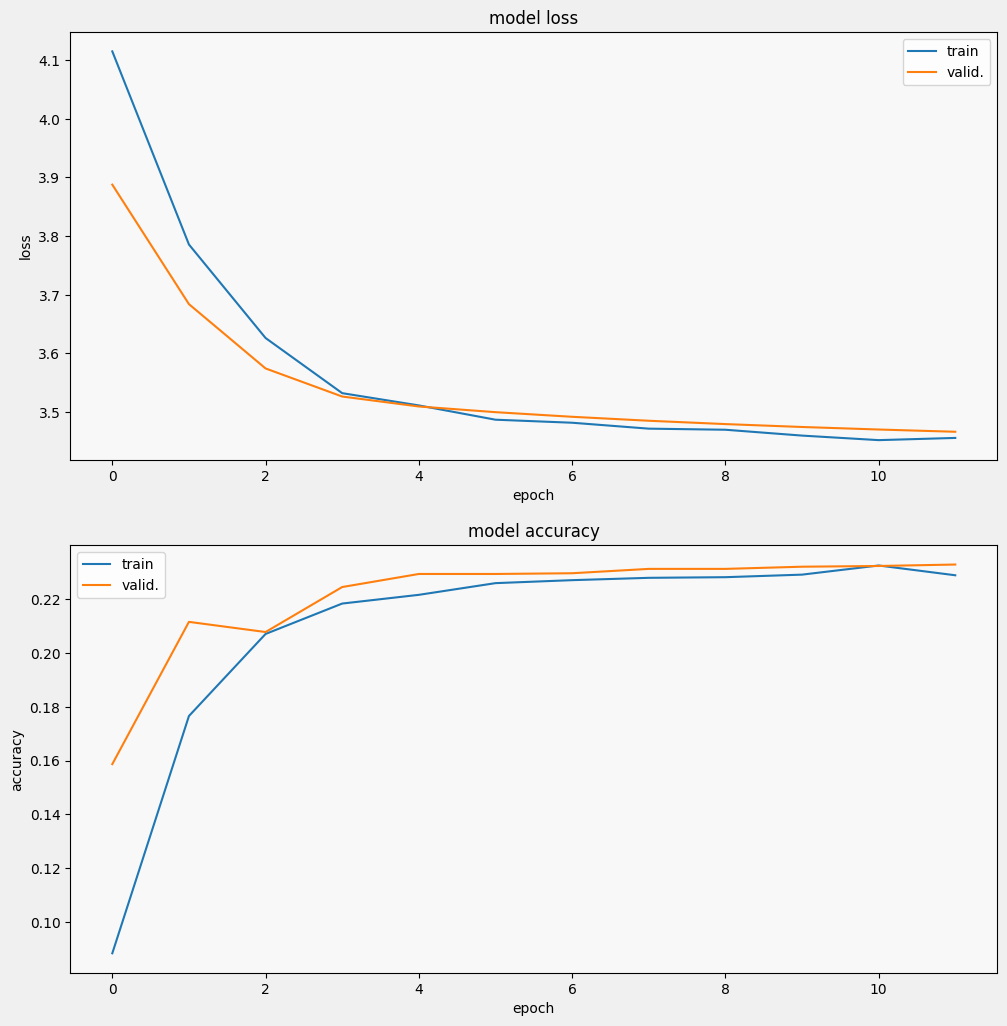

In [16]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [17]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/9.8 MB ? eta -:--:--

     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/9.8 MB 5.6 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━ 6.3/9.8 MB 60.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 9.8/9.8 MB 75.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 50.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 23.5 MB/s eta 0:00:00


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [19]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

2023-04-27 19:03:55.113325: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-27 19:03:55.206220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


      1/Unknown - 8s 8s/step

      2/Unknown - 9s 309ms/step

      3/Unknown - 9s 293ms/step

      4/Unknown - 9s 285ms/step

      5/Unknown - 9s 288ms/step

      6/Unknown - 10s 291ms/step

      7/Unknown - 10s 293ms/step

      8/Unknown - 10s 297ms/step

      9/Unknown - 11s 296ms/step

     10/Unknown - 11s 296ms/step

     11/Unknown - 11s 297ms/step

     12/Unknown - 12s 297ms/step

     13/Unknown - 12s 295ms/step

     14/Unknown - 12s 294ms/step

     15/Unknown - 12s 295ms/step

     16/Unknown - 13s 294ms/step

     17/Unknown - 13s 293ms/step

     18/Unknown - 13s 296ms/step

     19/Unknown - 14s 297ms/step

     20/Unknown - 14s 298ms/step

     21/Unknown - 14s 297ms/step

     22/Unknown - 15s 297ms/step

     23/Unknown - 15s 297ms/step

     24/Unknown - 15s 299ms/step

     25/Unknown - 15s 298ms/step

     26/Unknown - 16s 301ms/step

     27/Unknown - 16s 302ms/step

     28/Unknown - 16s 302ms/step

     29/Unknown - 17s 302ms/step

29/29 [==============================] - 17s 309ms/step


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


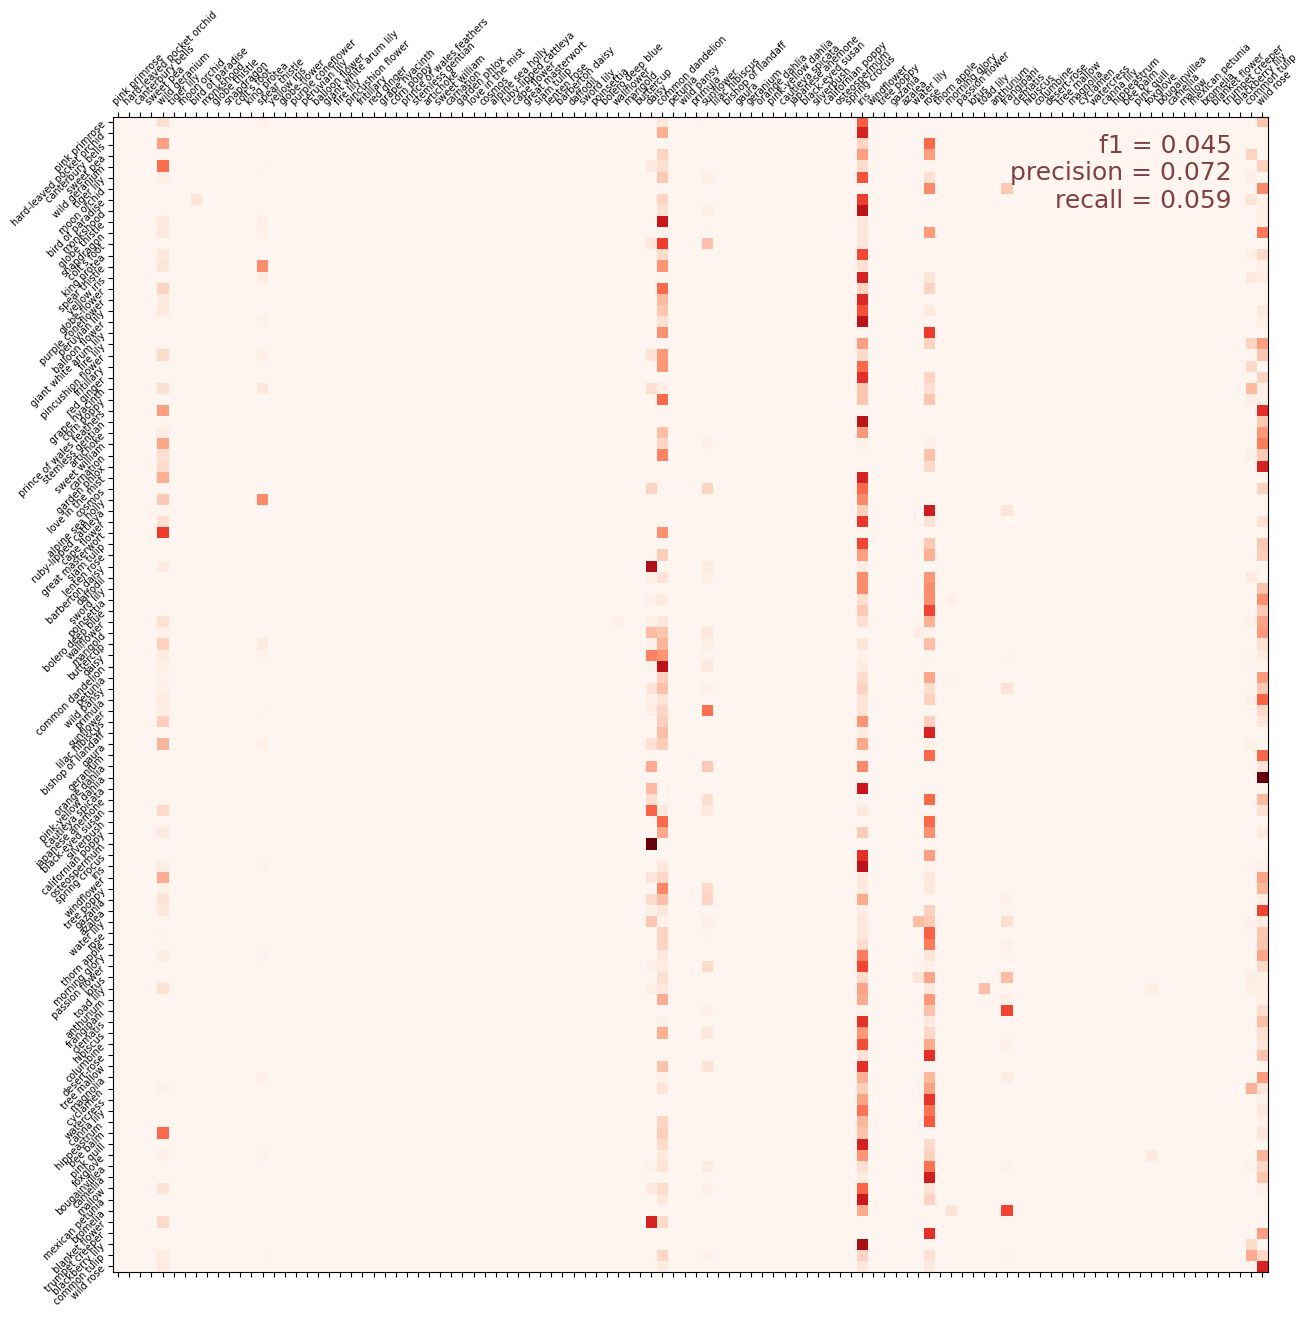

In [20]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

In [21]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 8s 8s/step


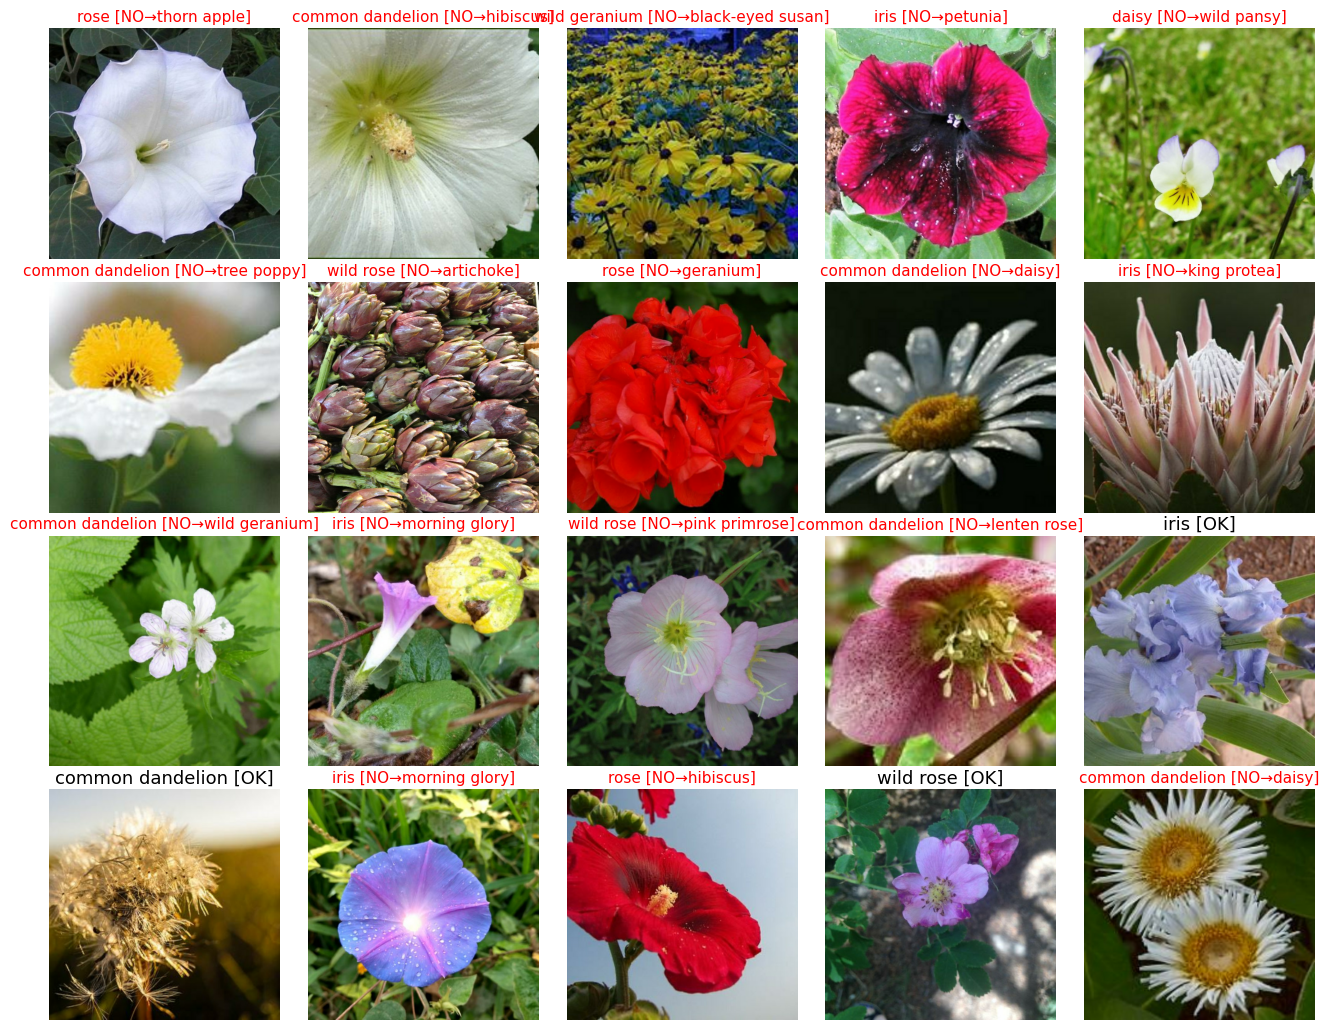

In [22]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

In [23]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...


      1/Unknown - 2s 2s/step

      2/Unknown - 2s 473ms/step

      3/Unknown - 3s 378ms/step

      4/Unknown - 3s 357ms/step

      5/Unknown - 3s 337ms/step

      6/Unknown - 4s 329ms/step

      7/Unknown - 4s 325ms/step

      8/Unknown - 4s 323ms/step

      9/Unknown - 5s 322ms/step

     10/Unknown - 5s 324ms/step

     11/Unknown - 5s 325ms/step

     12/Unknown - 5s 321ms/step

     13/Unknown - 6s 323ms/step

     14/Unknown - 6s 328ms/step

     15/Unknown - 7s 327ms/step

     16/Unknown - 7s 325ms/step

     17/Unknown - 7s 327ms/step

     18/Unknown - 7s 325ms/step

     19/Unknown - 8s 324ms/step

     20/Unknown - 8s 323ms/step

     21/Unknown - 8s 322ms/step

     22/Unknown - 9s 324ms/step

     23/Unknown - 9s 323ms/step

     24/Unknown - 9s 323ms/step

     25/Unknown - 10s 322ms/step

     26/Unknown - 10s 322ms/step

     27/Unknown - 10s 321ms/step

     28/Unknown - 11s 322ms/step

     29/Unknown - 11s 322ms/step

     30/Unknown - 11s 322ms/step

     31/Unknown - 12s 322ms/step

     32/Unknown - 12s 323ms/step

     33/Unknown - 12s 323ms/step

     34/Unknown - 13s 325ms/step

     35/Unknown - 13s 324ms/step

     36/Unknown - 13s 325ms/step

     37/Unknown - 14s 325ms/step

     38/Unknown - 14s 324ms/step

     39/Unknown - 14s 324ms/step

     40/Unknown - 15s 325ms/step

     41/Unknown - 15s 325ms/step

     42/Unknown - 15s 325ms/step

     43/Unknown - 16s 325ms/step

     44/Unknown - 16s 325ms/step

     45/Unknown - 16s 325ms/step

     46/Unknown - 17s 326ms/step

     47/Unknown - 17s 326ms/step

     48/Unknown - 17s 325ms/step

     49/Unknown - 18s 325ms/step

     50/Unknown - 18s 324ms/step

     51/Unknown - 18s 324ms/step

     52/Unknown - 19s 325ms/step

     53/Unknown - 19s 325ms/step

     54/Unknown - 19s 325ms/step

     55/Unknown - 19s 324ms/step

     56/Unknown - 20s 324ms/step

     57/Unknown - 20s 323ms/step

     58/Unknown - 26s 424ms/step

58/58 [==============================] - 26s 427ms/step


[ 49 103 103 ...  49 103  48]


In [24]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...


id,label
0b9afbdf2,49
c37a6f3e9,103
00e4f514e,103
1c4736dea,4
252d840db,67
dfc9c6a23,103
53cfc6586,49
541c4d41e,73
59d1b6146,53
